### Modelo Regresion Lineal

El codigo construira y evaluara un modelo de regresión lineal para predecir la cantidad de graduados (GRADUADOS) en función de variables relacionadas con indicadores educativos, demográficos y económicos. Se enfoca en preparar los datos, eliminar valores atípicos, escalar variables, codificar categorías y evaluar el modelo mediante validación cruzada.

Pasos desarrollados  

1. Carga y preprocesamiento de datos  
Se cargaron los datos desde un archivo Excel (Graduados_total.xlsx).  
Se eliminó los valores atípicos de la variable GRADUADOS utilizando el método de rango intercuartílico (IQR).  

2. Selección de variables  
Variable objetivo: GRADUADOS.  
Variables predictoras: Incluyen datos numéricos como DOCENTES, MATRICULADOS, VIOLENCIA y categóricos como AREA_CON y AÑO.  

3. Preparación para el modelado  
Se dividieron los datos en conjuntos de entrenamiento (80%) y prueba (20%).  
Las variables numéricas fueron escaladas con RobustScaler, mientras que las categóricas fueron codificadas con OneHotEncoder.  

4. Modelo y validación cruzada  
Se usó un modelo de regresión lineal (LinearRegression) con un pipeline que incluye preprocesamiento de los datos.  
Se aplicó validación cruzada con 10 divisiones para medir la estabilidad del modelo.  

5. Evaluación  
Se calcularon métricas como R², MSE (Error Cuadrático Medio) y MAE (Error Absoluto Medio) tanto en la validación cruzada como en el conjunto de prueba.  

Resultados:

En la validación cruzada, se obtuvo el promedio de R², MSE y MAE para evaluar la generalización del modelo en los datos de entrenamiento.  
En el conjunto de prueba, se calcularon las métricas para evaluar el desempeño en datos no vistos durante el entrenamiento.  

In [20]:
# Importamos las bibliotecas necesarias
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Cargamos el dataset
Graduados_total = pd.read_excel('Graduados_total.xlsx')

# Función para remover valores atípicos de una columna del DataFrame
def remover_atipicos(df, columna):
    q1, q3 = df[columna].quantile([0.25, 0.75])
    iqr = q3 - q1
    limite_bajo, limite_alto = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    return df[(df[columna] >= limite_bajo) & (df[columna] <= limite_alto)]

# Aplicamos la función para remover atípicos en la columna 'GRADUADOS'
Graduados_total = remover_atipicos(Graduados_total, 'GRADUADOS')

# Definición de variables objetivo y características
target = 'GRADUADOS'
x = Graduados_total.drop(columns=[target])
y = Graduados_total[target]

# Seleccionamos características numéricas y categóricas
columnas_numericas = [
    'DOCENTES',
    'MATRICULADOS', 'MATRICULADOS_P', 'POBLACION', 'DEFUNCIONES', 'PIB',
    'HOG_CABECERA', 'HOG_CPRD', 'HOG_TOTAL', 'INFLACION ANUAL%',
    'INFLACION TOTAL', 'CASOS_V', 'NACIMIENTOS'
]
columnas_categoricas = ['AREA_CON', 'AÑO']

# División de los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Escalamos la variable objetivo 'y' usando RobustScaler
scaler_y = RobustScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

# Definimos el preprocesador para los datos numéricos y categóricos
preprocesador = make_column_transformer(
    (RobustScaler(), columnas_numericas),
    (OneHotEncoder(sparse_output=False, handle_unknown='ignore'), columnas_categoricas)
)

# Creamos el pipeline de preprocesamiento y regresión lineal
modelo = make_pipeline(preprocesador, LinearRegression())

# Configuramos la validación cruzada
cv_folds = 10
kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)

# Inicializamos listas para las métricas de cada fold
r2_scores = []
mse_scores = []
mae_scores = []

# Validación cruzada personalizada
for train_idx, val_idx in kf.split(X_train):
    X_train_cv, X_val_cv = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_cv, y_val_cv = y_train_scaled[train_idx], y_train_scaled[val_idx]
    
    # Entrenamos el modelo
    modelo.fit(X_train_cv, y_train_cv)
    
    # Realizamos las predicciones
    y_pred_cv = modelo.predict(X_val_cv)
    
    # Calculamos las métricas
    r2_scores.append(modelo.score(X_val_cv, y_val_cv))
    mse_scores.append(mean_squared_error(y_val_cv, y_pred_cv))
    mae_scores.append(mean_absolute_error(y_val_cv, y_pred_cv))

# Evaluación en el conjunto de prueba
modelo.fit(X_train, y_train_scaled)
y_pred_test_scaled = modelo.predict(X_test)

# Métricas en el conjunto de prueba
r2_test = modelo.score(X_test, y_test_scaled)
mse_test = mean_squared_error(y_test_scaled, y_pred_test_scaled)
mae_test = mean_absolute_error(y_test_scaled, y_pred_test_scaled)

# Resultados de validación cruzada
print("Resultados de validación cruzada (escala normalizada):")
print("R² scores para cada fold:")
for i, score in enumerate(r2_scores, 1):
    print(f"  Fold {i}: {score:.4f}")
print("\nMSE para cada fold:")
for i, mse in enumerate(mse_scores, 1):
    print(f"  Fold {i}: {mse:.4f}")
print("\nMAE para cada fold:")
for i, mae in enumerate(mae_scores, 1):
    print(f"  Fold {i}: {mae:.4f}")

# Calcular y mostrar los promedios de las métricas
print("\nPromedios de validación cruzada (escala normalizada):")
print(f"  Promedio R²: {np.mean(r2_scores):.4f}")
print(f"  Promedio MSE: {np.mean(mse_scores):.4f}")
print(f"  Promedio MAE: {np.mean(mae_scores):.4f}")

# Resultados en el conjunto de prueba
print("\nResultados en el conjunto de prueba (escala normalizada):")
print(f"R² en el conjunto de testeo: {r2_test:.4f}")
print(f"MSE en el conjunto de testeo: {mse_test:.4f}")
print(f"MAE en el conjunto de testeo: {mae_test:.4f}")


Resultados de validación cruzada (escala normalizada):
R² scores para cada fold:
  Fold 1: 0.8321
  Fold 2: 0.8147
  Fold 3: 0.8776
  Fold 4: 0.8151
  Fold 5: 0.8612
  Fold 6: 0.7765
  Fold 7: 0.8284
  Fold 8: 0.8446
  Fold 9: 0.8747
  Fold 10: 0.8315

MSE para cada fold:
  Fold 1: 0.2300
  Fold 2: 0.2054
  Fold 3: 0.1470
  Fold 4: 0.1930
  Fold 5: 0.1995
  Fold 6: 0.2712
  Fold 7: 0.2103
  Fold 8: 0.1721
  Fold 9: 0.1237
  Fold 10: 0.2232

MAE para cada fold:
  Fold 1: 0.2829
  Fold 2: 0.2837
  Fold 3: 0.2418
  Fold 4: 0.2333
  Fold 5: 0.2669
  Fold 6: 0.2866
  Fold 7: 0.2458
  Fold 8: 0.2580
  Fold 9: 0.2429
  Fold 10: 0.2794

Promedios de validación cruzada (escala normalizada):
  Promedio R²: 0.8356
  Promedio MSE: 0.1975
  Promedio MAE: 0.2621

Resultados en el conjunto de prueba (escala normalizada):
R² en el conjunto de testeo: 0.8288
MSE en el conjunto de testeo: 0.2251
MAE en el conjunto de testeo: 0.2701


### Modelo de Regresion Polinomica

El objetivo del código es construir y evaluar un modelo de regresión lineal para predecir la cantidad de graduados (GRADUADOS) a partir de indicadores educativos, demográficos y económicos. En esta versión, se incorpora un enfoque de características polinómicas para mejorar la capacidad del modelo de capturar relaciones no lineales entre las variables predictoras y la variable objetivo.  

Pasos desarrollados: 

1. Carga y preprocesamiento de datos  
Se cargaron los datos desde un archivo Excel (Graduados_total.xlsx).  
Se eliminaron los valores atípicos de la variable GRADUADOS mediante el rango intercuartílico (IQR).  

2. Selección de variables  
Variable objetivo: GRADUADOS.  
Variables predictoras: Incluyen datos numéricos como DOCENTES , MATRÍCULADOS, VIOLENCIA y categóricos como AREA_CON y AÑO.  

3. Preparación para el modelado  
Se dividieron los datos en conjuntos de entrenamiento (80%) y prueba (20%).  
Las variables numéricas fueron escaladas con RobustScaler. Se aplicaron características polinómicas de segundo grado para capturar interacciones no lineales en las variables numéricas. Las variables categóricas fueron codificadas con OneHotEncoder.  

4. Modelo y validación cruzada  
Se utilizó un modelo de regresión lineal (LinearRegression) con un pipeline que incluye escalamiento, expansión polinómica y codificación.  
Se realizó validación cruzada con 10 divisiones para medir la estabilidad del modelo y evaluar su generalización en el conjunto de entrenamiento.  

5. Evaluación  
Se calcularon métricas como R², MSE (Error Cuadrático Medio) y MAE (Error Absoluto Medio) tanto en la validación cruzada como en el conjunto de prueba.  

Resultados:  

En la validación cruzada, se calculó el promedio de R², MSE y MAE, lo que permitió evaluar el desempeño del modelo en diferentes divisiones del conjunto de entrenamiento.  
En el conjunto de prueba, se midieron las métricas de desempeño para evaluar la capacidad predictiva del modelo en datos no utilizados durante el entrenamiento.  

In [24]:
# Importamos las bibliotecas necesarias
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Cargamos el dataset
Graduados_total = pd.read_excel('Graduados_total.xlsx') 

# Función para remover valores atípicos de una columna del DataFrame
def remover_atipicos(df, columna):
    q1, q3 = df[columna].quantile([0.25, 0.75])
    iqr = q3 - q1
    limite_bajo, limite_alto = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    return df[(df[columna] >= limite_bajo) & (df[columna] <= limite_alto)]

# Aplicamos la función para remover atípicos en la columna 'GRADUADOS'
Graduados_total = remover_atipicos(Graduados_total, 'GRADUADOS')

# Definición de variables objetivo y características
target = 'GRADUADOS'

x = Graduados_total.drop(columns=[target])
y = Graduados_total[target]

# Seleccionamos características numéricas y categóricas
columnas_numericas = [
    'DOCENTES',
    'MATRICULADOS', 'MATRICULADOS_P', 'POBLACION', 'DEFUNCIONES', 'PIB',
    'HOG_CABECERA', 'HOG_CPRD', 'HOG_TOTAL', 'INFLACION ANUAL%',
    'INFLACION TOTAL', 'CASOS_V', 'NACIMIENTOS'
]

columnas_categoricas = ['AREA_CON', 'AÑO']

# División de los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Escalamos la variable objetivo 'y' usando RobustScaler
scaler_y = RobustScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

# Definimos el preprocesador para los datos numéricos y categóricos
preprocesador = make_column_transformer(
    (RobustScaler(), columnas_numericas),
    (PolynomialFeatures(degree=2, include_bias=False), columnas_numericas),
    (OneHotEncoder(sparse_output=False, handle_unknown='ignore'), columnas_categoricas)
)

# Creamos el pipeline de preprocesamiento y regresión lineal
modelo = make_pipeline(preprocesador, LinearRegression())

# Configuramos la validación cruzada
cv_folds = 10
kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)

# Inicializamos listas para las métricas de cada fold
r2_scores = []
mse_scores = []
mae_scores = []

# Validación cruzada personalizada
for train_idx, val_idx in kf.split(X_train):
    X_train_cv, X_val_cv = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_cv, y_val_cv = y_train_scaled[train_idx], y_train_scaled[val_idx]
    
    # Entrenamos el modelo
    modelo.fit(X_train_cv, y_train_cv)
    
    # Realizamos las predicciones
    y_pred_cv = modelo.predict(X_val_cv)
    
    # Calculamos las métricas
    r2_scores.append(modelo.score(X_val_cv, y_val_cv))
    mse_scores.append(mean_squared_error(y_val_cv, y_pred_cv))
    mae_scores.append(mean_absolute_error(y_val_cv, y_pred_cv))

# Evaluación en el conjunto de prueba
modelo.fit(X_train, y_train_scaled)
y_pred_test_scaled = modelo.predict(X_test)

# Métricas en el conjunto de prueba
r2_test = modelo.score(X_test, y_test_scaled)
mse_test = mean_squared_error(y_test_scaled, y_pred_test_scaled)
mae_test = mean_absolute_error(y_test_scaled, y_pred_test_scaled)

# Resultados de validación cruzada
print("Resultados de validación cruzada (escala normalizada):")
print("R² scores para cada fold:")
for i, score in enumerate(r2_scores, 1):
    print(f"  Fold {i}: {score:.4f}")
print("\nMSE para cada fold:")
for i, mse in enumerate(mse_scores, 1):
    print(f"  Fold {i}: {mse:.4f}")
print("\nMAE para cada fold:")
for i, mae in enumerate(mae_scores, 1):
    print(f"  Fold {i}: {mae:.4f}")

# Calcular y mostrar los promedios de las métricas
print("\nPromedios de validación cruzada (escala normalizada):")
print(f"  Promedio R²: {np.mean(r2_scores):.4f}")
print(f"  Promedio MSE: {np.mean(mse_scores):.4f}")
print(f"  Promedio MAE: {np.mean(mae_scores):.4f}")

# Resultados en el conjunto de prueba
print("\nResultados en el conjunto de prueba (escala normalizada):")
print(f"R² en el conjunto de testeo: {r2_test:.4f}")
print(f"MSE en el conjunto de testeo: {mse_test:.4f}")
print(f"MAE en el conjunto de testeo: {mae_test:.4f}")


Resultados de validación cruzada (escala normalizada):
R² scores para cada fold:
  Fold 1: 0.7142
  Fold 2: 0.8265
  Fold 3: 0.7832
  Fold 4: 0.8084
  Fold 5: 0.8732
  Fold 6: 0.8123
  Fold 7: 0.9140
  Fold 8: 0.8813
  Fold 9: 0.8446
  Fold 10: 0.8021

MSE para cada fold:
  Fold 1: 0.3917
  Fold 2: 0.1924
  Fold 3: 0.2604
  Fold 4: 0.2000
  Fold 5: 0.1822
  Fold 6: 0.2278
  Fold 7: 0.1053
  Fold 8: 0.1314
  Fold 9: 0.1534
  Fold 10: 0.2621

MAE para cada fold:
  Fold 1: 0.2845
  Fold 2: 0.2656
  Fold 3: 0.2298
  Fold 4: 0.2383
  Fold 5: 0.2431
  Fold 6: 0.2568
  Fold 7: 0.2092
  Fold 8: 0.2370
  Fold 9: 0.2459
  Fold 10: 0.2727

Promedios de validación cruzada (escala normalizada):
  Promedio R²: 0.8260
  Promedio MSE: 0.2107
  Promedio MAE: 0.2483

Resultados en el conjunto de prueba (escala normalizada):
R² en el conjunto de testeo: 0.8408
MSE en el conjunto de testeo: 0.2093
MAE en el conjunto de testeo: 0.2539


### Modelo Regresion Lasso

El código busca predecir la cantidad de graduados (GRADUADOS) mediante un modelo de regresión basado en Lasso, que incluye selección de características y ajuste de hiperparámetros mediante búsqueda aleatoria (RandomizedSearchCV). Este enfoque optimiza el modelo y mejora la interpretabilidad al seleccionar únicamente las características relevantes.

Pasos desarrollados:  

1. Selección de características  
Se utilizó el modelo de Lasso para seleccionar automáticamente las variables predictoras más importantes eliminando aquellas con coeficientes cero. Esto asegura que el modelo sea más sencillo y enfocado en las variables relevantes.  

2. Preparación de los datos  
Se eliminaron valores atípicos de la variable GRADUADOS utilizando el rango intercuartílico (IQR).  
Se dividieron los datos en conjuntos de entrenamiento (80%) y prueba (20%).  
Se escaló la variable objetivo GRADUADOS utilizando RobustScaler para reducir el impacto de valores extremos.  

3. Ajuste de hiperparámetros  
Se configuró un pipeline que incluye escalado de las características seleccionadas y el modelo Lasso.  
Se realizó una búsqueda aleatoria de hiperparámetros (`alpha`, `fit_intercept`, `max_iter`) con 50 iteraciones y validación cruzada de 10 folds.  

4. Evaluación del modelo  
Se utilizó validación cruzada con 10 folds para medir la estabilidad y generalización del modelo sobre el conjunto de entrenamiento.  
Se evaluó el modelo final ajustado en el conjunto de prueba para calcular métricas como R², MSE y MAE.  

Resultados  

- Validación cruzada  
Se obtuvieron métricas de R², MSE y MAE en cada fold para evaluar el desempeño del modelo en los datos de entrenamiento. Se calcularon los promedios de estas métricas para validar la consistencia del modelo.  

- Conjunto de prueba  
El modelo ajustado se evaluó en datos no vistos durante el entrenamiento, logrando métricas finales que reflejan su capacidad de generalización.  



In [26]:
# Importamos las bibliotecas necesarias
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.linear_model import Lasso
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from scipy.stats import randint, uniform
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Cargamos el dataset
Graduados_total = pd.read_excel('Graduados_total.xlsx') 

# Verificamos si la columna 'GRADUADOS' está en el DataFrame antes de proceder
try:
    x_numeric = Graduados_total.select_dtypes(include='number').drop(columns=['GRADUADOS'])
except KeyError:
    x_numeric = Graduados_total.select_dtypes(include='number')

# Selección de características con Lasso
scaler = StandardScaler()
lasso = Lasso(alpha=0.1, random_state=42)
x_scaled = scaler.fit_transform(x_numeric)
lasso.fit(x_scaled, Graduados_total['GRADUADOS'])

# Máscara de características seleccionadas por Lasso
coeff_mask = np.array([coef != 0 for coef in lasso.coef_])
selected_features = x_numeric.columns[coeff_mask].tolist()

print("Características seleccionadas por Lasso:", selected_features)

# Función para remover valores atípicos de una columna del DataFrame
def remover_atipicos(df, columna):
    q1, q3 = df[columna].quantile([0.25, 0.75])
    iqr = q3 - q1
    limite_bajo, limite_alto = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    return df[(df[columna] >= limite_bajo) & (df[columna] <= limite_alto)]

# Aplicamos la función para remover valores atípicos en la columna 'GRADUADOS'
Graduados_total = remover_atipicos(Graduados_total, 'GRADUADOS')

# Definición de variables objetivo y características
x = Graduados_total[selected_features]
y = Graduados_total['GRADUADOS']

# División de los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Escalamos la variable objetivo 'y' usando RobustScaler
scaler_y = RobustScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

# Definimos el preprocesador para los datos numéricos
preprocesador = make_column_transformer(
    (RobustScaler(), selected_features),
    remainder='passthrough'
)

# Configuramos el pipeline con Lasso
pipeline = make_pipeline(
    preprocesador,
    Lasso(random_state=42)
)

# Definimos el espacio de hiperparámetros para Lasso
param_distributions = {
    'lasso__alpha': uniform(0.01, 1.0),
    'lasso__fit_intercept': [True, False],
    'lasso__max_iter': randint(1000, 5000)
}

# Configuramos RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=50,
    cv=10,
    scoring='r2',
    random_state=42,
    n_jobs=-1
)

# Entrenamos el modelo con la búsqueda aleatoria usando y_train_scaled
random_search.fit(X_train, y_train_scaled)

# Validación cruzada con 10 folds
kf = KFold(n_splits=10, shuffle=True, random_state=42)
r2_scores, mse_scores, mae_scores = [], [], []

for fold, (train_idx, test_idx) in enumerate(kf.split(X_train), 1):
    X_fold_train, X_fold_test = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_fold_train, y_fold_test = y_train_scaled[train_idx], y_train_scaled[test_idx]
    
    # Entrenamos el mejor modelo encontrado por RandomizedSearchCV
    best_model = random_search.best_estimator_
    best_model.fit(X_fold_train, y_fold_train)
    
    # Realizamos las predicciones
    y_fold_pred = best_model.predict(X_fold_test)
    
    # Calculamos las métricas sobre los valores escalados
    r2 = best_model.score(X_fold_test, y_fold_test)
    mse = mean_squared_error(y_fold_test, y_fold_pred)
    mae = mean_absolute_error(y_fold_test, y_fold_pred)
    
    r2_scores.append(r2)
    mse_scores.append(mse)
    mae_scores.append(mae)
    
    print(f"  Fold {fold}: R²={r2:.4f}, MSE={mse:.4f}, MAE={mae:.4f}")

# Resultados de la validación cruzada
print("\nResultados de validación cruzada (escala normalizada):")
print("R² scores para cada fold:")
for i, score in enumerate(r2_scores, 1):
    print(f"  Fold {i}: {score:.4f}")
print("\nMSE para cada fold:")
for i, mse in enumerate(mse_scores, 1):
    print(f"  Fold {i}: {mse:.4f}")
print("\nMAE para cada fold:")
for i, mae in enumerate(mae_scores, 1):
    print(f"  Fold {i}: {mae:.4f}")

# Calcular y mostrar los promedios de las métricas
print("\nPromedios de validación cruzada (escala normalizada):")
print(f"  Promedio R²: {np.mean(r2_scores):.4f}")
print(f"  Promedio MSE: {np.mean(mse_scores):.4f}")
print(f"  Promedio MAE: {np.mean(mae_scores):.4f}")

# Evaluación del modelo en el conjunto de prueba usando y_test_scaled
r2_test = random_search.best_estimator_.score(X_test, y_test_scaled)
y_pred_test_scaled = random_search.best_estimator_.predict(X_test)
mse_test = mean_squared_error(y_test_scaled, y_pred_test_scaled)
mae_test = mean_absolute_error(y_test_scaled, y_pred_test_scaled)

print("\nResultados en el conjunto de prueba (escala normalizada):")
print(f"R² en el conjunto de test: {r2_test:.4f}")
print(f"MSE en el conjunto de test: {mse_test:.4f}")
print(f"MAE en el conjunto de test: {mae_test:.4f}")


Características seleccionadas por Lasso: ['AÑO', 'COD_DEP', 'DOCENTES', 'MATRICULADOS', 'MATRICULADOS_P', 'POBLACION', 'DEFUNCIONES', 'PIB', 'HOG_CABECERA', 'HOG_CPRD', 'HOG_TOTAL', 'INFLACION ANUAL%', 'INFLACION TOTAL', 'CASOS_V', 'NACIMIENTOS']
  Fold 1: R²=0.8293, MSE=0.2339, MAE=0.2795
  Fold 2: R²=0.8114, MSE=0.2091, MAE=0.2793
  Fold 3: R²=0.8805, MSE=0.1435, MAE=0.2354
  Fold 4: R²=0.8095, MSE=0.1989, MAE=0.2362
  Fold 5: R²=0.8584, MSE=0.2036, MAE=0.2629
  Fold 6: R²=0.7739, MSE=0.2744, MAE=0.2825
  Fold 7: R²=0.8270, MSE=0.2120, MAE=0.2452
  Fold 8: R²=0.8466, MSE=0.1698, MAE=0.2557
  Fold 9: R²=0.8788, MSE=0.1196, MAE=0.2310
  Fold 10: R²=0.8254, MSE=0.2313, MAE=0.2805

Resultados de validación cruzada (escala normalizada):
R² scores para cada fold:
  Fold 1: 0.8293
  Fold 2: 0.8114
  Fold 3: 0.8805
  Fold 4: 0.8095
  Fold 5: 0.8584
  Fold 6: 0.7739
  Fold 7: 0.8270
  Fold 8: 0.8466
  Fold 9: 0.8788
  Fold 10: 0.8254

MSE para cada fold:
  Fold 1: 0.2339
  Fold 2: 0.2091
  Fo

### Modelo Regresion Ridge

El objetivo es construir un modelo de regresión Ridge para predecir la cantidad de graduados (GRADUADOS) basado en variables seleccionadas automáticamente y con ajuste de hiperparámetros para maximizar el desempeño predictivo. Ridge permite manejar problemas de multicolinealidad y regularización para evitar el sobreajuste.

Pasos desarrollados:  

1. Selección de características  
Se usó Ridge con regularización para identificar las variables predictoras más relevantes. Aunque Ridge no anula coeficientes como Lasso, permite reducir la influencia de variables menos importantes.  

2. Preparación de los datos  
Se eliminaron valores atípicos de la variable GRADUADOS utilizando el rango intercuartílico (IQR).  
Se dividieron los datos en conjuntos de entrenamiento (80%) y prueba (20%).  
Se escaló la variable objetivo GRADUADOS utilizando RobustScaler para reducir el impacto de valores extremos.  

3. Ajuste de hiperparámetros  
Se configuró un pipeline que incluye el preprocesamiento y el modelo Ridge.  
Se realizó una búsqueda aleatoria de hiperparámetros, incluyendo `alpha` (intensidad de regularización), `solver` (algoritmo de optimización), `fit_intercept` (ajuste del intercepto) y `max_iter` (iteraciones máximas).  

4. Validación cruzada  
Se utilizó validación cruzada con 10 folds para medir la estabilidad y generalización del modelo sobre el conjunto de entrenamiento.  

5. Evaluación del modelo  
El modelo final ajustado fue evaluado en el conjunto de prueba mediante métricas como R², MSE y MAE, escalando las variables objetivo para una evaluación más consistente.  

Resultados: 

- Validación cruzada  
Se obtuvieron métricas de R², MSE y MAE en cada fold para evaluar el desempeño del modelo en los datos de entrenamiento. Los promedios de estas métricas muestran el desempeño general del modelo en diferentes particiones.  

- Conjunto de prueba  
El modelo ajustado fue evaluado en datos no utilizados durante el entrenamiento. Los resultados reflejan la capacidad de generalización del modelo.  

In [27]:
# Importamos las bibliotecas necesarias
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.linear_model import Ridge
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from scipy.stats import randint, uniform
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Cargamos el dataset
Graduados_total = pd.read_excel('Graduados_total.xlsx') 

# Verificamos si la columna 'GRADUADOS' está en el DataFrame antes de proceder
try:
    x_numeric = Graduados_total.select_dtypes(include='number').drop(columns=['GRADUADOS'])
except KeyError:
    x_numeric = Graduados_total.select_dtypes(include='number')

# Selección de características con Ridge
scaler = StandardScaler()
ridge_selector = Ridge(alpha=0.1, random_state=42)
x_scaled = scaler.fit_transform(x_numeric)
ridge_selector.fit(x_scaled, Graduados_total['GRADUADOS'])

# Máscara de características seleccionadas por Ridge (si se desea mantener la selección)
coeff_mask = np.array([coef != 0 for coef in ridge_selector.coef_])
selected_features = x_numeric.columns[coeff_mask].tolist()

print("Características seleccionadas por Ridge:", selected_features)

# Función para remover valores atípicos de una columna del DataFrame
def remover_atipicos(df, columna):
    q1, q3 = df[columna].quantile([0.25, 0.75])
    iqr = q3 - q1
    limite_bajo, limite_alto = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    return df[(df[columna] >= limite_bajo) & (df[columna] <= limite_alto)]

# Aplicamos la función para remover valores atípicos en la columna 'GRADUADOS'
Graduados_total = remover_atipicos(Graduados_total, 'GRADUADOS')

# Definición de variables objetivo y características
x = Graduados_total[selected_features]
y = Graduados_total['GRADUADOS']

# División de los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Escalamos la variable objetivo 'y' usando RobustScaler
scaler_y = RobustScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

# Definimos el preprocesador para los datos numéricos
preprocesador = make_column_transformer(
    (RobustScaler(), selected_features),
    remainder='passthrough'
)

# Configuramos el pipeline con Ridge
pipeline = make_pipeline(
    preprocesador,
    Ridge(random_state=42)
)

# Definimos el espacio de hiperparámetros para Ridge
param_distributions = {
    'ridge__alpha': uniform(0.01, 10.0),
    'ridge__fit_intercept': [True, False],
    'ridge__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
    'ridge__max_iter': randint(1000, 5000)
}

# Configuramos RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=50,
    cv=10,
    scoring='r2',
    random_state=42,
    n_jobs=-1
)

# Entrenamos el modelo con la búsqueda aleatoria usando y_train_scaled
random_search.fit(X_train, y_train_scaled)

# Validación cruzada con 10 folds
kf = KFold(n_splits=10, shuffle=True, random_state=42)
r2_scores, mse_scores, mae_scores = [], [], []

for fold, (train_idx, test_idx) in enumerate(kf.split(X_train), 1):
    X_fold_train, X_fold_test = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_fold_train, y_fold_test = y_train_scaled[train_idx], y_train_scaled[test_idx]
    
    # Entrenamos el mejor modelo encontrado por RandomizedSearchCV
    best_model = random_search.best_estimator_
    best_model.fit(X_fold_train, y_fold_train)
    
    # Realizamos las predicciones
    y_fold_pred = best_model.predict(X_fold_test)
    
    # Calculamos las métricas sobre los valores escalados
    r2 = best_model.score(X_fold_test, y_fold_test)
    mse = mean_squared_error(y_fold_test, y_fold_pred)
    mae = mean_absolute_error(y_fold_test, y_fold_pred)
    
    r2_scores.append(r2)
    mse_scores.append(mse)
    mae_scores.append(mae)
    
    print(f"  Fold {fold}: R²={r2:.4f}, MSE={mse:.4f}, MAE={mae:.4f}")

# Resultados de la validación cruzada
print("\nResultados de validación cruzada (escala normalizada):")
print("R² scores para cada fold:")
for i, score in enumerate(r2_scores, 1):
    print(f"  Fold {i}: {score:.4f}")
print("\nMSE para cada fold:")
for i, mse in enumerate(mse_scores, 1):
    print(f"  Fold {i}: {mse:.4f}")
print("\nMAE para cada fold:")
for i, mae in enumerate(mae_scores, 1):
    print(f"  Fold {i}: {mae:.4f}")

# Calcular y mostrar los promedios de las métricas
print("\nPromedios de validación cruzada (escala normalizada):")
print(f"  Promedio R²: {np.mean(r2_scores):.4f}")
print(f"  Promedio MSE: {np.mean(mse_scores):.4f}")
print(f"  Promedio MAE: {np.mean(mae_scores):.4f}")

# Evaluación del modelo en el conjunto de prueba usando y_test_scaled
r2_test = random_search.best_estimator_.score(X_test, y_test_scaled)
y_pred_test_scaled = random_search.best_estimator_.predict(X_test)
mse_test = mean_squared_error(y_test_scaled, y_pred_test_scaled)
mae_test = mean_absolute_error(y_test_scaled, y_pred_test_scaled)

print("\nResultados en el conjunto de prueba (escala normalizada):")
print(f"R² en el conjunto de test: {r2_test:.4f}")
print(f"MSE en el conjunto de test: {mse_test:.4f}")
print(f"MAE en el conjunto de test: {mae_test:.4f}")


Características seleccionadas por Ridge: ['AÑO', 'COD_DEP', 'COD_MUN', 'DOCENTES', 'MATRICULADOS', 'MATRICULADOS_P', 'POBLACION', 'DEFUNCIONES', 'PIB', 'HOG_CABECERA', 'HOG_CPRD', 'HOG_TOTAL', 'INFLACION ANUAL%', 'INFLACION TOTAL', 'CASOS_V', 'NACIMIENTOS']
  Fold 1: R²=0.8326, MSE=0.2294, MAE=0.2737
  Fold 2: R²=0.8117, MSE=0.2088, MAE=0.2812
  Fold 3: R²=0.8806, MSE=0.1434, MAE=0.2351
  Fold 4: R²=0.8140, MSE=0.1941, MAE=0.2334
  Fold 5: R²=0.8585, MSE=0.2033, MAE=0.2628
  Fold 6: R²=0.7769, MSE=0.2707, MAE=0.2807
  Fold 7: R²=0.8244, MSE=0.2152, MAE=0.2429
  Fold 8: R²=0.8456, MSE=0.1709, MAE=0.2554
  Fold 9: R²=0.8764, MSE=0.1220, MAE=0.2336
  Fold 10: R²=0.8273, MSE=0.2288, MAE=0.2740

Resultados de validación cruzada (escala normalizada):
R² scores para cada fold:
  Fold 1: 0.8326
  Fold 2: 0.8117
  Fold 3: 0.8806
  Fold 4: 0.8140
  Fold 5: 0.8585
  Fold 6: 0.7769
  Fold 7: 0.8244
  Fold 8: 0.8456
  Fold 9: 0.8764
  Fold 10: 0.8273

MSE para cada fold:
  Fold 1: 0.2294
  Fold 2: 

### Modelo Regresion Elastic Net

El objetivo del modelo es predecir la cantidad de graduados (GRADUADOS) utilizando ElasticNet, un modelo de regresión que combina las propiedades de Lasso y Ridge para realizar selección de características y regularización. Este enfoque equilibra la simplicidad del modelo y la reducción de multicolinealidad, buscando maximizar el desempeño predictivo.

Pasos desarrollados:

1. Selección de características  
Se utilizó ElasticNet con una combinación de penalización L1 (Lasso) y L2 (Ridge) para identificar las variables más relevantes. Las características seleccionadas se basan en los coeficientes no nulos del modelo.  

2. Preparación de los datos  
Se eliminaron valores atípicos en la variable GRADUADOS mediante el rango intercuartílico (IQR).  
Se dividieron los datos en conjuntos de entrenamiento (80%) y prueba (20%).  
Se escaló la variable objetivo GRADUADOS utilizando RobustScaler para reducir la influencia de valores extremos.  

3. Configuración del modelo y ajuste de hiperparámetros  
Se creó un pipeline que incluye preprocesamiento de datos (escalado) y el modelo ElasticNet.  
Se exploraron combinaciones de hiperparámetros utilizando RandomizedSearchCV. Los parámetros ajustados incluyeron:  
- `alpha`: Intensidad de la regularización.  
- `l1_ratio`: Proporción entre las penalizaciones L1 y L2.  
- `fit_intercept`: Inclusión del intercepto en el modelo.  
- `max_iter`: Número máximo de iteraciones.  

4. Validación cruzada  
Se empleó validación cruzada con 10 folds para evaluar el desempeño del modelo ajustado en múltiples divisiones del conjunto de entrenamiento.  

5. Evaluación del modelo  
El modelo ajustado se evaluó en el conjunto de prueba utilizando métricas como R², MSE y MAE, escalando las variables objetivo para obtener resultados más consistentes.  

Resultados: 

- Validación cruzada  
En cada fold de la validación cruzada, se calcularon las métricas R², MSE y MAE para medir el desempeño del modelo en el conjunto de entrenamiento. Los promedios de estas métricas reflejan la consistencia del modelo.  

- Conjunto de prueba  
El modelo final se evaluó en datos no utilizados durante el entrenamiento, proporcionando métricas que reflejan su capacidad de generalización.  

In [28]:
# Importamos las bibliotecas necesarias
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from scipy.stats import randint, uniform
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Cargamos el dataset
Graduados_total = pd.read_excel('Graduados_total.xlsx') 

# Verificamos si la columna 'GRADUADOS' está en el DataFrame antes de proceder
try:
    x_numeric = Graduados_total.select_dtypes(include='number').drop(columns=['GRADUADOS'])
except KeyError:
    x_numeric = Graduados_total.select_dtypes(include='number')

# Selección de características con ElasticNet
scaler = StandardScaler()
elasticnet_selector = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
x_scaled = scaler.fit_transform(x_numeric)
elasticnet_selector.fit(x_scaled, Graduados_total['GRADUADOS'])

# Máscara de características seleccionadas por ElasticNet
coeff_mask = np.array([coef != 0 for coef in elasticnet_selector.coef_])
selected_features = x_numeric.columns[coeff_mask].tolist()

print("Características seleccionadas por ElasticNet:", selected_features)

# Función para remover valores atípicos de una columna del DataFrame
def remover_atipicos(df, columna):
    q1, q3 = df[columna].quantile([0.25, 0.75])
    iqr = q3 - q1
    limite_bajo, limite_alto = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    return df[(df[columna] >= limite_bajo) & (df[columna] <= limite_alto)]

# Aplicamos la función para remover valores atípicos en la columna 'GRADUADOS'
Graduados_total = remover_atipicos(Graduados_total, 'GRADUADOS')

# Definición de variables objetivo y características
x = Graduados_total[selected_features]
y = Graduados_total['GRADUADOS']

# División de los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Escalamos la variable objetivo 'y' usando RobustScaler
scaler_y = RobustScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

# Definimos el preprocesador para los datos numéricos
preprocesador = make_column_transformer(
    (RobustScaler(), selected_features),
    remainder='passthrough'
)

# Configuramos el pipeline con ElasticNet
pipeline = make_pipeline(
    preprocesador,
    ElasticNet(random_state=42)
)

# Definimos el espacio de hiperparámetros para ElasticNet
param_distributions = {
    'elasticnet__alpha': uniform(0.01, 10.0),
    'elasticnet__fit_intercept': [True, False],
    'elasticnet__l1_ratio': uniform(0.0, 1.0),
    'elasticnet__max_iter': randint(1000, 5000)
}

# Configuramos RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=50,
    cv=10,
    scoring='r2',
    random_state=42,
    n_jobs=-1
)

# Entrenamos el modelo con la búsqueda aleatoria usando y_train_scaled
random_search.fit(X_train, y_train_scaled)

# Validación cruzada con 10 folds
kf = KFold(n_splits=10, shuffle=True, random_state=42)
r2_scores, mse_scores, mae_scores = [], [], []

for fold, (train_idx, test_idx) in enumerate(kf.split(X_train), 1):
    X_fold_train, X_fold_test = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_fold_train, y_fold_test = y_train_scaled[train_idx], y_train_scaled[test_idx]
    
    # Entrenamos el mejor modelo encontrado por RandomizedSearchCV
    best_model = random_search.best_estimator_
    best_model.fit(X_fold_train, y_fold_train)
    
    # Realizamos las predicciones
    y_fold_pred = best_model.predict(X_fold_test)
    
    # Calculamos las métricas sobre los valores escalados
    r2 = best_model.score(X_fold_test, y_fold_test)
    mse = mean_squared_error(y_fold_test, y_fold_pred)
    mae = mean_absolute_error(y_fold_test, y_fold_pred)
    
    r2_scores.append(r2)
    mse_scores.append(mse)
    mae_scores.append(mae)
    
    print(f"  Fold {fold}: R²={r2:.4f}, MSE={mse:.4f}, MAE={mae:.4f}")

# Resultados de la validación cruzada
print("\nResultados de validación cruzada (escala normalizada):")
print("R² scores para cada fold:")
for i, score in enumerate(r2_scores, 1):
    print(f"  Fold {i}: {score:.4f}")
print("\nMSE para cada fold:")
for i, mse in enumerate(mse_scores, 1):
    print(f"  Fold {i}: {mse:.4f}")
print("\nMAE para cada fold:")
for i, mae in enumerate(mae_scores, 1):
    print(f"  Fold {i}: {mae:.4f}")

# Calcular y mostrar los promedios de las métricas
print("\nPromedios de validación cruzada (escala normalizada):")
print(f"  Promedio R²: {np.mean(r2_scores):.4f}")
print(f"  Promedio MSE: {np.mean(mse_scores):.4f}")
print(f"  Promedio MAE: {np.mean(mae_scores):.4f}")

# Evaluación del modelo en el conjunto de prueba usando y_test_scaled
r2_test = random_search.best_estimator_.score(X_test, y_test_scaled)
y_pred_test_scaled = random_search.best_estimator_.predict(X_test)
mse_test = mean_squared_error(y_test_scaled, y_pred_test_scaled)
mae_test = mean_absolute_error(y_test_scaled, y_pred_test_scaled)

print("\nResultados en el conjunto de prueba (escala normalizada):")
print(f"R² en el conjunto de test: {r2_test:.4f}")
print(f"MSE en el conjunto de test: {mse_test:.4f}")
print(f"MAE en el conjunto de test: {mae_test:.4f}")


Características seleccionadas por ElasticNet: ['AÑO', 'COD_DEP', 'COD_MUN', 'DOCENTES', 'MATRICULADOS', 'MATRICULADOS_P', 'POBLACION', 'DEFUNCIONES', 'PIB', 'HOG_CABECERA', 'HOG_CPRD', 'HOG_TOTAL', 'INFLACION ANUAL%', 'INFLACION TOTAL', 'CASOS_V', 'NACIMIENTOS']
  Fold 1: R²=0.8356, MSE=0.2252, MAE=0.2801
  Fold 2: R²=0.8081, MSE=0.2127, MAE=0.2846
  Fold 3: R²=0.8796, MSE=0.1446, MAE=0.2377
  Fold 4: R²=0.8072, MSE=0.2013, MAE=0.2395
  Fold 5: R²=0.8556, MSE=0.2075, MAE=0.2674
  Fold 6: R²=0.7694, MSE=0.2798, MAE=0.2882
  Fold 7: R²=0.8348, MSE=0.2024, MAE=0.2463
  Fold 8: R²=0.8465, MSE=0.1699, MAE=0.2597
  Fold 9: R²=0.8765, MSE=0.1220, MAE=0.2344
  Fold 10: R²=0.8281, MSE=0.2277, MAE=0.2819

Resultados de validación cruzada (escala normalizada):
R² scores para cada fold:
  Fold 1: 0.8356
  Fold 2: 0.8081
  Fold 3: 0.8796
  Fold 4: 0.8072
  Fold 5: 0.8556
  Fold 6: 0.7694
  Fold 7: 0.8348
  Fold 8: 0.8465
  Fold 9: 0.8765
  Fold 10: 0.8281

MSE para cada fold:
  Fold 1: 0.2252
  Fol

### Modelo KNN

El objetivo es predecir la cantidad de graduados (GRADUADOS) utilizando un modelo K-Nearest Neighbors (KNN). Este enfoque no paramétrico se basa en calcular distancias entre puntos para realizar predicciones basadas en los vecinos más cercanos, optimizando el número de vecinos y la métrica de distancia mediante una búsqueda aleatoria de hiperparámetros.

Pasos desarrollados: 

1. Preparación de los datos  
Se eliminaron valores atípicos en la variable GRADUADOS utilizando el rango intercuartílico (IQR).  
Se dividieron los datos en conjuntos de entrenamiento (80%) y prueba (20%).  
Se utilizaron dos tipos de datos:  
- Variables numéricas: Indicadores como `DOCENTES`, `MATRICULADOS`, `PIB`.  
- Variables categóricas: Incluyen `AREA_CON` y `AÑO`.  
Se escaló la variable objetivo GRADUADOS usando RobustScaler para reducir la influencia de valores extremos.  

2. Configuración del modelo KNN  
Se creó un pipeline que incluyó:  
- Preprocesamiento: Escalado de variables numéricas y codificación one-hot para variables categóricas.  
- Modelo KNN: Predicción basada en los vecinos más cercanos.  

3. Ajuste de hiperparámetros  
Se exploraron combinaciones de hiperparámetros mediante RandomizedSearchCV, incluyendo:  
- `n_neighbors`: Número de vecinos a considerar.  
- `weights`: Estrategia de ponderación (`uniform` o basada en la distancia).  
- `metric`: Métrica de distancia (`euclidean`, `manhattan`, `minkowski`).  

4. Validación cruzada  
Se realizó validación cruzada con 10 folds para evaluar la estabilidad y generalización del modelo ajustado en el conjunto de entrenamiento.  

5. Evaluación del modelo  
El modelo ajustado se evaluó en el conjunto de prueba utilizando métricas como R², MSE y MAE.  

Resultados  

- Validación cruzada  
Se calcularon métricas de desempeño (R², MSE y MAE) en cada fold de la validación cruzada, y se promediaron los resultados para evaluar la consistencia del modelo.  

- Conjunto de prueba  
El modelo optimizado se evaluó en datos no utilizados durante el entrenamiento, mostrando las siguientes métricas:  
  - R²: Medida de la proporción de variabilidad explicada por el modelo.  
  - MSE: Magnitud promedio de los errores cuadrados.  
  - MAE: Error absoluto promedio.  

In [29]:
# Importamos las bibliotecas necesarias
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.neighbors import KNeighborsRegressor  # Importamos KNeighborsRegressor
from sklearn.preprocessing import RobustScaler, OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from scipy.stats import randint, uniform
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Cargamos el dataset
Graduados_total = pd.read_excel('Graduados_total.xlsx') 

# Función para remover valores atípicos de una columna del DataFrame
def remover_atipicos(df, columna):
    q1, q3 = df[columna].quantile([0.25, 0.75])
    iqr = q3 - q1
    limite_bajo, limite_alto = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    return df[(df[columna] >= limite_bajo) & (df[columna] <= limite_alto)]

# Aplicamos la función para remover atípicos en la columna 'GRADUADOS'
Graduados_total = remover_atipicos(Graduados_total, 'GRADUADOS')

# Definición de variables objetivo y características
target = 'GRADUADOS'
x = Graduados_total.drop(columns=[target])
y = Graduados_total[target]

# Seleccionamos características numéricas y categóricas
columnas_numericas = [
    'DOCENTES',
    'MATRICULADOS', 'MATRICULADOS_P', 'POBLACION', 'DEFUNCIONES', 'PIB',
    'HOG_CABECERA', 'HOG_CPRD', 'HOG_TOTAL', 'INFLACION ANUAL%',
    'INFLACION TOTAL', 'CASOS_V', 'NACIMIENTOS'
]

columnas_categoricas = ['AREA_CON', 'AÑO']

# División de los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

# Escalamos la variable objetivo 'y' usando RobustScaler
scaler_y = RobustScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

# Definimos el preprocesador para los datos numéricos y categóricos
preprocesador = make_column_transformer(
    (RobustScaler(), columnas_numericas),
    (OneHotEncoder(sparse_output=False, handle_unknown='ignore'), columnas_categoricas)
)

# Creamos el pipeline de preprocesamiento y regresión KNN
pipeline = make_pipeline(
    preprocesador,
    KNeighborsRegressor()
)

# Definimos el espacio de hiperparámetros para KNN centrado en encontrar el mejor valor de k
param_distributions = {
    'kneighborsregressor__n_neighbors': randint(1, 30),          # Número de vecinos (k)
    'kneighborsregressor__weights': ['uniform', 'distance'],     # Tipo de ponderación
    'kneighborsregressor__metric': ['euclidean', 'manhattan', 'minkowski']  # Métrica de distancia
}

# Configuramos RandomizedSearchCV para optimizar los hiperparámetros de KNN
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=50,            # Número de combinaciones a probar
    cv=5,                 # Validación cruzada con 5 folds
    scoring='r2',         # Métrica de evaluación
    random_state=42,
    n_jobs=-1             # Utiliza todos los núcleos disponibles
)

# Entrenamos el modelo con la búsqueda aleatoria usando y_train_scaled
random_search.fit(X_train, y_train_scaled)

# Validación cruzada con 10 folds
kf = KFold(n_splits=10, shuffle=True, random_state=42)
r2_scores, mse_scores, mae_scores = [], [], []

for fold, (train_idx, test_idx) in enumerate(kf.split(X_train), 1):
    X_fold_train, X_fold_test = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_fold_train, y_fold_test = y_train_scaled[train_idx], y_train_scaled[test_idx]
    
    # Entrenamos el mejor modelo encontrado por RandomizedSearchCV
    best_model = random_search.best_estimator_
    best_model.fit(X_fold_train, y_fold_train)
    
    # Realizamos las predicciones
    y_fold_pred = best_model.predict(X_fold_test)
    
    # Calculamos las métricas sobre los valores escalados
    r2 = best_model.score(X_fold_test, y_fold_test)
    mse = mean_squared_error(y_fold_test, y_fold_pred)
    mae = mean_absolute_error(y_fold_test, y_fold_pred)
    
    r2_scores.append(r2)
    mse_scores.append(mse)
    mae_scores.append(mae)
    
    print(f"  Fold {fold}: R²={r2:.4f}, MSE={mse:.4f}, MAE={mae:.4f}")

# Resultados de la validación cruzada
print("\nResultados de validación cruzada (escala normalizada):")
print("R² scores para cada fold:")
for i, score in enumerate(r2_scores, 1):
    print(f"  Fold {i}: {score:.4f}")
print("\nMSE para cada fold:")
for i, mse in enumerate(mse_scores, 1):
    print(f"  Fold {i}: {mse:.4f}")
print("\nMAE para cada fold:")
for i, mae in enumerate(mae_scores, 1):
    print(f"  Fold {i}: {mae:.4f}")

# Calcular y mostrar los promedios de las métricas
print("\nPromedios de validación cruzada (escala normalizada):")
print(f"  Promedio R²: {np.mean(r2_scores):.4f}")
print(f"  Promedio MSE: {np.mean(mse_scores):.4f}")
print(f"  Promedio MAE: {np.mean(mae_scores):.4f}")

# Evaluación del modelo en el conjunto de prueba usando y_test_scaled
r2_test = random_search.best_estimator_.score(X_test, y_test_scaled)
y_pred_test_scaled = random_search.best_estimator_.predict(X_test)
mse_test = mean_squared_error(y_test_scaled, y_pred_test_scaled)
mae_test = mean_absolute_error(y_test_scaled, y_pred_test_scaled)

print("\nResultados en el conjunto de prueba (escala normalizada):")
print(f"R² en el conjunto de test: {r2_test:.4f}")
print(f"MSE en el conjunto de test: {mse_test:.4f}")
print(f"MAE en el conjunto de test: {mae_test:.4f}")


  Fold 1: R²=0.8566, MSE=0.1964, MAE=0.2609
  Fold 2: R²=0.7789, MSE=0.2451, MAE=0.2791
  Fold 3: R²=0.8534, MSE=0.1761, MAE=0.2654
  Fold 4: R²=0.8234, MSE=0.1843, MAE=0.2406
  Fold 5: R²=0.8387, MSE=0.2319, MAE=0.2678
  Fold 6: R²=0.7164, MSE=0.3442, MAE=0.3197
  Fold 7: R²=0.8709, MSE=0.1582, MAE=0.2249
  Fold 8: R²=0.8696, MSE=0.1444, MAE=0.2332
  Fold 9: R²=0.7920, MSE=0.2053, MAE=0.2577
  Fold 10: R²=0.8097, MSE=0.2521, MAE=0.2910

Resultados de validación cruzada (escala normalizada):
R² scores para cada fold:
  Fold 1: 0.8566
  Fold 2: 0.7789
  Fold 3: 0.8534
  Fold 4: 0.8234
  Fold 5: 0.8387
  Fold 6: 0.7164
  Fold 7: 0.8709
  Fold 8: 0.8696
  Fold 9: 0.7920
  Fold 10: 0.8097

MSE para cada fold:
  Fold 1: 0.1964
  Fold 2: 0.2451
  Fold 3: 0.1761
  Fold 4: 0.1843
  Fold 5: 0.2319
  Fold 6: 0.3442
  Fold 7: 0.1582
  Fold 8: 0.1444
  Fold 9: 0.2053
  Fold 10: 0.2521

MAE para cada fold:
  Fold 1: 0.2609
  Fold 2: 0.2791
  Fold 3: 0.2654
  Fold 4: 0.2406
  Fold 5: 0.2678
  Fold 6

### Modelo de Arboles de Desicion

El objetivo del proyecto es predecir la cantidad de graduados GRADUADOS utilizando un modelo basado en Árboles de Decisión. Este modelo no paramétrico permite capturar relaciones complejas y no lineales entre las variables predictoras y la variable objetivo. Además, se realizó una optimización de hiperparámetros mediante RandomizedSearchCV para maximizar el desempeño del modelo.

Pasos desarrollados:  

1. Preparación de los datos  
Se eliminaron valores atípicos de la variable GRADUADOS utilizando el rango intercuartílico IQR.  
Se dividieron los datos en conjuntos de entrenamiento 80 por ciento y prueba 20 por ciento.  
Los datos se clasificaron en  
Variables numéricas Indicadores como DOCENTES, MATRICULADOS, PIB  
Variables categóricas Incluyen AREA_CON y AÑO  
La variable objetivo GRADUADOS fue escalada usando RobustScaler para reducir la influencia de valores extremos.  

2. Configuración del modelo de Árboles de Decisión  
Se implementó un pipeline que incluyó  
Preprocesamiento Escalado de variables numéricas y codificación one-hot para variables categóricas  
Modelo Árboles de Decisión DecisionTreeRegressor para realizar predicciones basadas en divisiones jerárquicas de los datos  

3. Ajuste de hiperparámetros con RandomizedSearchCV  
Para optimizar el modelo se utilizó RandomizedSearchCV, que realiza una búsqueda aleatoria sobre un espacio definido de hiperparámetros. Los parámetros explorados fueron  
max_depth Profundidad máxima del árbol, con valores entre 1 y 20  
min_samples_split Mínimo de muestras necesarias para dividir un nodo, valores entre 2 y 20  
min_samples_leaf Mínimo de muestras requeridas en una hoja, valores entre 1 y 20  
max_features Número de características a considerar al dividir un nodo sqrt, log2 o None  
criterion Criterio para medir la calidad de una división squared_error, friedman_mse, absolute_error  

Se ejecutaron 50 iteraciones de combinaciones aleatorias de estos hiperparámetros con validación cruzada de 5 folds. El mejor modelo se seleccionó en función de la métrica R².  

4. Validación cruzada  
Se aplicó validación cruzada con 10 folds para evaluar la estabilidad y generalización del modelo ajustado en el conjunto de entrenamiento.  

5. Evaluación del modelo  
El modelo final ajustado se evaluó en el conjunto de prueba utilizando métricas como R², MSE y MAE.  

Resultados:  

Búsqueda de hiperparámetros con RandomizedSearchCV  
El modelo óptimo fue determinado con los siguientes hiperparámetros  
Profundidad máxima del árbol max_depth valor ajustado por el proceso  
Muestras mínimas para dividir un nodo min_samples_split valor ajustado  
Muestras mínimas en una hoja min_samples_leaf valor ajustado  
Criterio para dividir criterion criterio seleccionado  

El modelo con estos hiperparámetros mostró el mejor desempeño en el conjunto de entrenamiento y validación.

Validación cruzada  
Se calcularon las métricas R², MSE y MAE en cada fold, con resultados promedio que reflejan la estabilidad y generalización del modelo.  

Conjunto de prueba  
El modelo ajustado se evaluó en datos no vistos durante el entrenamiento mostrando  
R² Proporción de la variación explicada por el modelo  
MSE Magnitud promedio de los errores cuadrados  
MAE Error absoluto promedio  

In [30]:
# Importamos las bibliotecas necesarias
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.tree import DecisionTreeRegressor  # Importamos DecisionTreeRegressor
from sklearn.preprocessing import RobustScaler, OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from scipy.stats import randint, uniform
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Cargamos el dataset
Graduados_total = pd.read_excel('Graduados_total.xlsx') 

# Función para remover valores atípicos de una columna del DataFrame
def remover_atipicos(df, columna):
    q1, q3 = df[columna].quantile([0.25, 0.75])
    iqr = q3 - q1
    limite_bajo, limite_alto = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    return df[(df[columna] >= limite_bajo) & (df[columna] <= limite_alto)]

# Aplicamos la función para remover atípicos en la columna 'GRADUADOS'
Graduados_total = remover_atipicos(Graduados_total, 'GRADUADOS')

# Definición de variables objetivo y características
target = 'GRADUADOS'
x = Graduados_total.drop(columns=[target])
y = Graduados_total[target]

# Seleccionamos características numéricas y categóricas
columnas_numericas = [
    'DOCENTES',
    'MATRICULADOS', 'MATRICULADOS_P', 'POBLACION', 'DEFUNCIONES', 'PIB',
    'HOG_CABECERA', 'HOG_CPRD', 'HOG_TOTAL', 'INFLACION ANUAL%',
    'INFLACION TOTAL', 'CASOS_V', 'NACIMIENTOS'
]

columnas_categoricas = ['AREA_CON', 'AÑO']

# División de los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

# Escalamos la variable objetivo 'y' usando RobustScaler
scaler_y = RobustScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

# Definimos el preprocesador para los datos numéricos y categóricos
preprocesador = make_column_transformer(
    (RobustScaler(), columnas_numericas),
    (OneHotEncoder(sparse_output=False, handle_unknown='ignore'), columnas_categoricas)
)

# Creamos el pipeline de preprocesamiento y regresión de Árboles de Decisión
pipeline = make_pipeline(
    preprocesador,
    DecisionTreeRegressor(random_state=42)
)

# Definimos el espacio de hiperparámetros para DecisionTreeRegressor (sin 'auto')
param_distributions = {
    'decisiontreeregressor__max_depth': randint(1, 20),                # Profundidad máxima del árbol
    'decisiontreeregressor__min_samples_split': randint(2, 20),        # Mínimo de muestras para dividir un nodo
    'decisiontreeregressor__min_samples_leaf': randint(1, 20),         # Mínimo de muestras en una hoja
    'decisiontreeregressor__max_features': ['sqrt', 'log2', None],    # Número de características a considerar al buscar la mejor división
    'decisiontreeregressor__criterion': ['squared_error', 'friedman_mse', 'absolute_error']  # Criterio de división
}

# Configuramos RandomizedSearchCV para optimizar los hiperparámetros de DecisionTreeRegressor
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=50,            # Número de combinaciones a probar
    cv=5,                 # Validación cruzada con 5 folds
    scoring='r2',         # Métrica de evaluación
    random_state=42,
    n_jobs=-1             # Utiliza todos los núcleos disponibles
)

# Entrenamos el modelo con la búsqueda aleatoria usando y_train_scaled
random_search.fit(X_train, y_train_scaled)

# Validación cruzada con 10 folds
kf = KFold(n_splits=10, shuffle=True, random_state=42)
r2_scores, mse_scores, mae_scores = [], [], []

for fold, (train_idx, test_idx) in enumerate(kf.split(X_train), 1):
    X_fold_train, X_fold_test = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_fold_train, y_fold_test = y_train_scaled[train_idx], y_train_scaled[test_idx]
    
    # Entrenamos el mejor modelo encontrado por RandomizedSearchCV
    best_model = random_search.best_estimator_
    best_model.fit(X_fold_train, y_fold_train)
    
    # Realizamos las predicciones
    y_fold_pred = best_model.predict(X_fold_test)
    
    # Calculamos las métricas sobre los valores escalados
    r2 = best_model.score(X_fold_test, y_fold_test)
    mse = mean_squared_error(y_fold_test, y_fold_pred)
    mae = mean_absolute_error(y_fold_test, y_fold_pred)
    
    r2_scores.append(r2)
    mse_scores.append(mse)
    mae_scores.append(mae)
    
    print(f"  Fold {fold}: R²={r2:.4f}, MSE={mse:.4f}, MAE={mae:.4f}")

# Resultados de la validación cruzada
print("\nResultados de validación cruzada (escala normalizada):")
print("R² scores para cada fold:")
for i, score in enumerate(r2_scores, 1):
    print(f"  Fold {i}: {score:.4f}")
print("\nMSE para cada fold:")
for i, mse in enumerate(mse_scores, 1):
    print(f"  Fold {i}: {mse:.4f}")
print("\nMAE para cada fold:")
for i, mae in enumerate(mae_scores, 1):
    print(f"  Fold {i}: {mae:.4f}")

# Calcular y mostrar los promedios de las métricas
print("\nPromedios de validación cruzada (escala normalizada):")
print(f"  Promedio R²: {np.mean(r2_scores):.4f}")
print(f"  Promedio MSE: {np.mean(mse_scores):.4f}")
print(f"  Promedio MAE: {np.mean(mae_scores):.4f}")

# Evaluación del modelo en el conjunto de prueba usando y_test_scaled
r2_test = random_search.best_estimator_.score(X_test, y_test_scaled)
y_pred_test_scaled = random_search.best_estimator_.predict(X_test)
mse_test = mean_squared_error(y_test_scaled, y_pred_test_scaled)
mae_test = mean_absolute_error(y_test_scaled, y_pred_test_scaled)

print("\nResultados en el conjunto de prueba (escala normalizada):")
print(f"R² en el conjunto de test: {r2_test:.4f}")
print(f"MSE en el conjunto de test: {mse_test:.4f}")
print(f"MAE en el conjunto de test: {mae_test:.4f}")


  Fold 1: R²=0.7192, MSE=0.3848, MAE=0.2795
  Fold 2: R²=0.7773, MSE=0.2469, MAE=0.2656
  Fold 3: R²=0.8198, MSE=0.2164, MAE=0.2587
  Fold 4: R²=0.8000, MSE=0.2087, MAE=0.2396
  Fold 5: R²=0.7758, MSE=0.3223, MAE=0.3036
  Fold 6: R²=0.7686, MSE=0.2807, MAE=0.2521
  Fold 7: R²=0.8705, MSE=0.1586, MAE=0.2192
  Fold 8: R²=0.8352, MSE=0.1824, MAE=0.2511
  Fold 9: R²=0.8365, MSE=0.1614, MAE=0.2439
  Fold 10: R²=0.8175, MSE=0.2417, MAE=0.2526

Resultados de validación cruzada (escala normalizada):
R² scores para cada fold:
  Fold 1: 0.7192
  Fold 2: 0.7773
  Fold 3: 0.8198
  Fold 4: 0.8000
  Fold 5: 0.7758
  Fold 6: 0.7686
  Fold 7: 0.8705
  Fold 8: 0.8352
  Fold 9: 0.8365
  Fold 10: 0.8175

MSE para cada fold:
  Fold 1: 0.3848
  Fold 2: 0.2469
  Fold 3: 0.2164
  Fold 4: 0.2087
  Fold 5: 0.3223
  Fold 6: 0.2807
  Fold 7: 0.1586
  Fold 8: 0.1824
  Fold 9: 0.1614
  Fold 10: 0.2417

MAE para cada fold:
  Fold 1: 0.2795
  Fold 2: 0.2656
  Fold 3: 0.2587
  Fold 4: 0.2396
  Fold 5: 0.3036
  Fold 6

### Modelo Ramdom Forest

El objetivo del proyecto es predecir la cantidad de graduados GRADUADOS utilizando un modelo basado en Random Forest. Este enfoque de aprendizaje en conjunto permite capturar relaciones complejas y no lineales en los datos mediante la combinación de múltiples árboles de decisión. Para mejorar el rendimiento del modelo, se realizó una optimización de hiperparámetros con RandomizedSearchCV.

Pasos desarrollados:  

1. Preparación de los datos  
Se eliminaron valores atípicos en la variable GRADUADOS utilizando el rango intercuartílico IQR.  
Los datos se dividieron en conjuntos de entrenamiento 80 por ciento y prueba 20 por ciento.  
Se clasificaron los datos en  
Variables numéricas Indicadores como DOCENTES, MATRICULADOS, PIB.  
Variables categóricas Incluyen AREA_CON y AÑO.  
La variable objetivo GRADUADOS se escaló utilizando RobustScaler para reducir la influencia de valores extremos.  

2. Configuración del modelo de Random Forest  
Se implementó un pipeline que incluyó  
Preprocesamiento Escalado de variables numéricas y codificación one-hot para variables categóricas.  
Modelo Random Forest RandomForestRegressor para realizar predicciones mediante el promedio de múltiples árboles de decisión.  

3. Ajuste de hiperparámetros con RandomizedSearchCV  
Se utilizó RandomizedSearchCV para explorar combinaciones de hiperparámetros clave en Random Forest. Los parámetros ajustados incluyeron  
n_estimators Número de árboles en el bosque, valores entre 100 y 1000.  
max_depth Profundidad máxima de los árboles, valores entre 1 y 30.  
min_samples_split Mínimo de muestras requeridas para dividir un nodo, valores entre 2 y 20.  
min_samples_leaf Mínimo de muestras en una hoja, valores entre 1 y 20.  
max_features Número de características consideradas para dividir un nodo sqrt, log2 o None.  
bootstrap Si usar muestreo con reemplazo True o sin reemplazo False.  
criterion Criterio para medir la calidad de las divisiones squared_error, absolute_error, poisson.  

Se ejecutaron 50 combinaciones aleatorias de hiperparámetros con validación cruzada de 5 folds para identificar el modelo óptimo según la métrica R².

4. Validación cruzada  
Se aplicó validación cruzada con 10 folds para evaluar la estabilidad y generalización del modelo ajustado en el conjunto de entrenamiento.  

5. Evaluación del modelo  
El modelo final se evaluó en el conjunto de prueba utilizando métricas como R², MSE y MAE.  

Resultados:  

Búsqueda de hiperparámetros con RandomizedSearchCV  
El modelo óptimo fue determinado con los siguientes hiperparámetros  
Número de árboles n_estimators valor ajustado.  
Profundidad máxima max_depth valor ajustado.  
Muestras mínimas para dividir un nodo min_samples_split valor ajustado.  
Muestras mínimas en una hoja min_samples_leaf valor ajustado.  
Criterio para medir divisiones criterion valor ajustado.  

El modelo con estos hiperparámetros mostró un desempeño consistente y efectivo en el conjunto de entrenamiento y validación.

Validación cruzada  
Se calcularon las métricas R², MSE y MAE en cada fold. Los promedios reflejan un buen desempeño del modelo en diferentes particiones de los datos.  

Conjunto de prueba  
El modelo ajustado se evaluó en datos no utilizados durante el entrenamiento con los siguientes resultados  
R² Proporción de la variación explicada por el modelo.  
MSE Magnitud promedio de los errores cuadrados.  
MAE Error absoluto promedio.  

In [31]:
# Importamos las bibliotecas necesarias
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor  # Importamos RandomForestRegressor
from sklearn.preprocessing import RobustScaler, OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from scipy.stats import randint, uniform
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import warnings

# Opcional: Suprimir advertencias para una salida más limpia
warnings.filterwarnings('ignore')

# Cargamos el dataset
Graduados_total = pd.read_excel('Graduados_total.xlsx')

# Función para remover valores atípicos de una columna del DataFrame
def remover_atipicos(df, columna):
    q1, q3 = df[columna].quantile([0.25, 0.75])
    iqr = q3 - q1
    limite_bajo, limite_alto = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    return df[(df[columna] >= limite_bajo) & (df[columna] <= limite_alto)]

# Aplicamos la función para remover valores atípicos en la columna 'GRADUADOS'
Graduados_total = remover_atipicos(Graduados_total, 'GRADUADOS')

# Definición de variables objetivo y características
target = 'GRADUADOS'
x = Graduados_total.drop(columns=[target])
y = Graduados_total[target]

# Seleccionamos características numéricas y categóricas
columnas_numericas = [
    'DOCENTES',
    'MATRICULADOS', 'MATRICULADOS_P', 'POBLACION', 'DEFUNCIONES', 'PIB',
    'HOG_CABECERA', 'HOG_CPRD', 'HOG_TOTAL', 'INFLACION ANUAL%',
    'INFLACION TOTAL', 'CASOS_V', 'NACIMIENTOS'
]

columnas_categoricas = ['AREA_CON', 'AÑO']

# División de los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

# Escalamos la variable objetivo 'y' usando RobustScaler
scaler_y = RobustScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

# Definimos el preprocesador para los datos numéricos y categóricos
preprocesador = make_column_transformer(
    (RobustScaler(), columnas_numericas),
    (OneHotEncoder(sparse_output=False, handle_unknown='ignore'), columnas_categoricas)
)

# Creamos el pipeline de preprocesamiento y regresión de Random Forest
pipeline = make_pipeline(
    preprocesador,
    RandomForestRegressor(random_state=42)
)

# Definimos el espacio de hiperparámetros para RandomForestRegressor
param_distributions = {
    'randomforestregressor__n_estimators': randint(100, 1000),
    'randomforestregressor__max_depth': randint(1, 30),
    'randomforestregressor__min_samples_split': randint(2, 20),
    'randomforestregressor__min_samples_leaf': randint(1, 20),
    'randomforestregressor__max_features': ['sqrt', 'log2', None],
    'randomforestregressor__bootstrap': [True, False],
    'randomforestregressor__criterion': ['squared_error', 'absolute_error', 'poisson']
}

# Configuramos RandomizedSearchCV para optimizar los hiperparámetros de RandomForestRegressor
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=50,            # Número de combinaciones a probar
    cv=5,                 # Validación cruzada con 5 folds
    scoring='r2',         # Métrica de evaluación
    random_state=42,
    n_jobs=-1,            # Utiliza todos los núcleos disponibles
    verbose=1,
    error_score=np.nan
)

# Entrenamos el modelo con la búsqueda aleatoria usando y_train_scaled
random_search.fit(X_train, y_train_scaled)

# Validación cruzada con 10 folds
kf = KFold(n_splits=10, shuffle=True, random_state=42)
r2_scores, mse_scores, mae_scores = [], [], []

for fold, (train_idx, test_idx) in enumerate(kf.split(X_train), 1):
    X_fold_train, X_fold_test = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_fold_train, y_fold_test = y_train_scaled[train_idx], y_train_scaled[test_idx]
    
    # Entrenamos el mejor modelo encontrado por RandomizedSearchCV
    best_model = random_search.best_estimator_
    best_model.fit(X_fold_train, y_fold_train)
    
    # Realizamos las predicciones
    y_fold_pred = best_model.predict(X_fold_test)
    
    # Calculamos las métricas sobre los valores escalados
    r2 = best_model.score(X_fold_test, y_fold_test)
    mse = mean_squared_error(y_fold_test, y_fold_pred)
    mae = mean_absolute_error(y_fold_test, y_fold_pred)
    
    r2_scores.append(r2)
    mse_scores.append(mse)
    mae_scores.append(mae)
    
    print(f"  Fold {fold}: R²={r2:.4f}, MSE={mse:.4f}, MAE={mae:.4f}")

# Resultados de la validación cruzada
print("\nResultados de validación cruzada (escala normalizada):")
print("R² scores para cada fold:")
for i, score in enumerate(r2_scores, 1):
    print(f"  Fold {i}: {score:.4f}")
print("\nMSE para cada fold:")
for i, mse in enumerate(mse_scores, 1):
    print(f"  Fold {i}: {mse:.4f}")
print("\nMAE para cada fold:")
for i, mae in enumerate(mae_scores, 1):
    print(f"  Fold {i}: {mae:.4f}")

# Calcular y mostrar los promedios de las métricas
print("\nPromedios de validación cruzada (escala normalizada):")
print(f"  Promedio R²: {np.mean(r2_scores):.4f}")
print(f"  Promedio MSE: {np.mean(mse_scores):.4f}")
print(f"  Promedio MAE: {np.mean(mae_scores):.4f}")

# Evaluación del modelo en el conjunto de prueba usando y_test_scaled
r2_test = random_search.best_estimator_.score(X_test, y_test_scaled)
y_pred_test_scaled = random_search.best_estimator_.predict(X_test)
mse_test = mean_squared_error(y_test_scaled, y_pred_test_scaled)
mae_test = mean_absolute_error(y_test_scaled, y_pred_test_scaled)

print("\nResultados en el conjunto de prueba (escala normalizada):")
print(f"R² en el conjunto de test: {r2_test:.4f}")
print(f"MSE en el conjunto de test: {mse_test:.4f}")
print(f"MAE en el conjunto de test: {mae_test:.4f}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
  Fold 1: R²=0.8770, MSE=0.1685, MAE=0.2090
  Fold 2: R²=0.8315, MSE=0.1868, MAE=0.2328
  Fold 3: R²=0.9173, MSE=0.0994, MAE=0.1859
  Fold 4: R²=0.9006, MSE=0.1037, MAE=0.1729
  Fold 5: R²=0.9050, MSE=0.1365, MAE=0.2110
  Fold 6: R²=0.8781, MSE=0.1480, MAE=0.2083
  Fold 7: R²=0.8925, MSE=0.1318, MAE=0.1988
  Fold 8: R²=0.9001, MSE=0.1106, MAE=0.2036
  Fold 9: R²=0.8570, MSE=0.1411, MAE=0.2222
  Fold 10: R²=0.9123, MSE=0.1162, MAE=0.2015

Resultados de validación cruzada (escala normalizada):
R² scores para cada fold:
  Fold 1: 0.8770
  Fold 2: 0.8315
  Fold 3: 0.9173
  Fold 4: 0.9006
  Fold 5: 0.9050
  Fold 6: 0.8781
  Fold 7: 0.8925
  Fold 8: 0.9001
  Fold 9: 0.8570
  Fold 10: 0.9123

MSE para cada fold:
  Fold 1: 0.1685
  Fold 2: 0.1868
  Fold 3: 0.0994
  Fold 4: 0.1037
  Fold 5: 0.1365
  Fold 6: 0.1480
  Fold 7: 0.1318
  Fold 8: 0.1106
  Fold 9: 0.1411
  Fold 10: 0.1162

MAE para cada fold:
  Fold 1: 0.2090
  Fold 2: 0.23

### Modelo Bagging

El objetivo del proyecto es predecir la cantidad de graduados GRADUADOS utilizando un modelo basado en Bagging Regressor. Este enfoque de aprendizaje en conjunto combina múltiples estimadores base, en este caso DecisionTreeRegressor, para mejorar la estabilidad y la precisión del modelo. Se realizó una optimización de hiperparámetros con RandomizedSearchCV para maximizar el rendimiento del modelo.

Pasos desarrollados:  

1. Preparación de los datos  
Se eliminaron valores atípicos en la variable GRADUADOS utilizando el rango intercuartílico IQR.  
Los datos se dividieron en conjuntos de entrenamiento 80 por ciento y prueba 20 por ciento.  
Se clasificaron los datos en  
Variables numéricas Indicadores como DOCENTES, MATRICULADOS, PIB.  
Variables categóricas Incluyen AREA_CON y AÑO.  
La variable objetivo GRADUADOS se escaló utilizando RobustScaler para reducir la influencia de valores extremos.  

2. Configuración del modelo de Bagging Regressor  
Se implementó un pipeline que incluyó  
Preprocesamiento Escalado de variables numéricas y codificación one-hot para variables categóricas.  
Modelo Bagging Regressor, con DecisionTreeRegressor como estimador base, para realizar predicciones mediante el promedio de múltiples estimadores.  

3. Ajuste de hiperparámetros con RandomizedSearchCV  
Se utilizó RandomizedSearchCV para explorar combinaciones de hiperparámetros clave tanto para Bagging Regressor como para su estimador base DecisionTreeRegressor. Los parámetros ajustados incluyeron  
n_estimators Número de estimadores en el conjunto, valores entre 10 y 100.  
max_samples Fracción de muestras para entrenar cada estimador, valores entre 0.5 y 1.  
max_features Fracción de características para entrenar cada estimador, valores entre 0.5 y 1.  
bootstrap Uso de bootstrap True o False.  
max_depth Profundidad máxima de los árboles, valores entre 1 y 30.  
min_samples_split Mínimo de muestras para dividir un nodo, valores entre 2 y 20.  
min_samples_leaf Mínimo de muestras en una hoja, valores entre 1 y 20.  

Se ejecutaron 50 combinaciones aleatorias de hiperparámetros con validación cruzada de 5 folds para identificar el modelo óptimo según la métrica R².

4. Validación cruzada  
Se aplicó validación cruzada con 10 folds para evaluar la estabilidad y generalización del modelo ajustado en el conjunto de entrenamiento.  

5. Evaluación del modelo  
El modelo final se evaluó en el conjunto de prueba utilizando métricas como R², MSE y MAE.  

Resultados:  

Búsqueda de hiperparámetros con RandomizedSearchCV  
El modelo óptimo fue determinado con los siguientes hiperparámetros  
Número de estimadores n_estimators valor ajustado.  
Fracción de muestras max_samples valor ajustado.  
Fracción de características max_features valor ajustado.  
Profundidad máxima max_depth valor ajustado.  
Muestras mínimas para dividir un nodo min_samples_split valor ajustado.  

El modelo con estos hiperparámetros mostró un desempeño consistente y efectivo en el conjunto de entrenamiento y validación.

Validación cruzada  
Se calcularon las métricas R², MSE y MAE en cada fold. Los promedios reflejan un buen desempeño del modelo en diferentes particiones de los datos.  

Conjunto de prueba  
El modelo ajustado se evaluó en datos no utilizados durante el entrenamiento con los siguientes resultados  
R² Proporción de la variación explicada por el modelo.  
MSE Magnitud promedio de los errores cuadrados.  
MAE Error absoluto promedio.

In [32]:
# Importamos las bibliotecas necesarias
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.ensemble import BaggingRegressor  # Importamos BaggingRegressor
from sklearn.tree import DecisionTreeRegressor  # Importamos DecisionTreeRegressor para especificar como base
from sklearn.preprocessing import RobustScaler, OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from scipy.stats import randint, uniform
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# Opcional: Suprimir advertencias para una salida más limpia
warnings.filterwarnings('ignore')

# Cargamos el dataset
Graduados_total = pd.read_excel('Graduados_total.xlsx') 

# Función para remover valores atípicos de una columna del DataFrame
def remover_atipicos(df, columna):
    q1, q3 = df[columna].quantile([0.25, 0.75])
    iqr = q3 - q1
    limite_bajo, limite_alto = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    return df[(df[columna] >= limite_bajo) & (df[columna] <= limite_alto)]

# Aplicamos la función para remover valores atípicos en la columna 'GRADUADOS'
Graduados_total = remover_atipicos(Graduados_total, 'GRADUADOS')

# Definición de variables objetivo y características
target = 'GRADUADOS'
x = Graduados_total.drop(columns=[target])
y = Graduados_total[target]

# Seleccionamos características numéricas y categóricas
columnas_numericas = [
    'DOCENTES',
    'MATRICULADOS', 'MATRICULADOS_P', 'POBLACION', 'DEFUNCIONES', 'PIB',
    'HOG_CABECERA', 'HOG_CPRD', 'HOG_TOTAL', 'INFLACION ANUAL%',
    'INFLACION TOTAL', 'CASOS_V', 'NACIMIENTOS'
]
columnas_categoricas = ['AREA_CON', 'AÑO']

# División de los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

# Escalamos la variable objetivo 'y' usando RobustScaler
scaler_y = RobustScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

# Definimos el preprocesador para los datos numéricos y categóricos
preprocesador = make_column_transformer(
    (RobustScaler(), columnas_numericas),
    (OneHotEncoder(sparse_output=False, handle_unknown='ignore'), columnas_categoricas)
)

# Creamos el pipeline de preprocesamiento y regresión de Bagging Regressor con DecisionTreeRegressor como base
pipeline = make_pipeline(
    preprocesador,
    BaggingRegressor(
        estimator=DecisionTreeRegressor(random_state=42),
        random_state=42
    )
)

# Definimos el espacio de hiperparámetros para BaggingRegressor y su estimador base DecisionTreeRegressor
param_distributions = {
    # Hiperparámetros de BaggingRegressor
    'baggingregressor__n_estimators': randint(10, 100),               # Número de estimadores
    'baggingregressor__max_samples': uniform(0.5, 0.5),              # Fracción de muestras para entrenar cada estimador
    'baggingregressor__max_features': uniform(0.5, 0.5),             # Fracción de características para entrenar cada estimador
    'baggingregressor__bootstrap': [True, False],                     # Uso de bootstrap samples
    
    # Hiperparámetros del estimador base DecisionTreeRegressor
    'baggingregressor__estimator__max_depth': randint(1, 30),        # Profundidad máxima del árbol
    'baggingregressor__estimator__min_samples_split': randint(2, 20),# Mínimo de muestras para dividir un nodo
    'baggingregressor__estimator__min_samples_leaf': randint(1, 20), # Mínimo de muestras en una hoja
    'baggingregressor__estimator__max_features': ['sqrt', 'log2', None],  # Número de características a considerar al buscar la mejor división
}

# Configuramos RandomizedSearchCV para optimizar los hiperparámetros de BaggingRegressor y DecisionTreeRegressor
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=50,            # Número de combinaciones a probar
    cv=5,                 # Validación cruzada con 5 folds
    scoring='r2',         # Métrica de evaluación
    random_state=42,
    n_jobs=-1,            # Utiliza todos los núcleos disponibles
    verbose=1,            # Para ver el progreso de la búsqueda
    error_score=np.nan    # Asigna NaN en caso de error, evitando fallos completos
)

# Entrenamos el modelo con la búsqueda aleatoria usando y_train_scaled
random_search.fit(X_train, y_train_scaled)

# Validación cruzada con 10 folds
kf = KFold(n_splits=10, shuffle=True, random_state=42)
r2_scores, mse_scores, mae_scores = [], [], []

for fold, (train_idx, test_idx) in enumerate(kf.split(X_train), 1):
    X_fold_train, X_fold_test = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_fold_train, y_fold_test = y_train_scaled[train_idx], y_train_scaled[test_idx]
    
    # Entrenamos el mejor modelo encontrado por RandomizedSearchCV
    best_model = random_search.best_estimator_
    best_model.fit(X_fold_train, y_fold_train)
    
    # Realizamos las predicciones
    y_fold_pred = best_model.predict(X_fold_test)
    
    # Calculamos las métricas sobre los valores escalados
    r2 = best_model.score(X_fold_test, y_fold_test)
    mse = mean_squared_error(y_fold_test, y_fold_pred)
    mae = mean_absolute_error(y_fold_test, y_fold_pred)
    
    r2_scores.append(r2)
    mse_scores.append(mse)
    mae_scores.append(mae)
    
    print(f"  Fold {fold}: R²={r2:.4f}, MSE={mse:.4f}, MAE={mae:.4f}")

# Resultados de la validación cruzada
print("\nResultados de validación cruzada (escala normalizada):")
print("R² scores para cada fold:")
for i, score in enumerate(r2_scores, 1):
    print(f"  Fold {i}: {score:.4f}")
print("\nMSE para cada fold:")
for i, mse in enumerate(mse_scores, 1):
    print(f"  Fold {i}: {mse:.4f}")
print("\nMAE para cada fold:")
for i, mae in enumerate(mae_scores, 1):
    print(f"  Fold {i}: {mae:.4f}")

# Calcular y mostrar los promedios de las métricas
print("\nPromedios de validación cruzada (escala normalizada):")
print(f"  Promedio R²: {np.mean(r2_scores):.4f}")
print(f"  Promedio MSE: {np.mean(mse_scores):.4f}")
print(f"  Promedio MAE: {np.mean(mae_scores):.4f}")

# Evaluación del modelo optimizado en el conjunto de prueba usando y_test_scaled
r2_test = random_search.best_estimator_.score(X_test, y_test_scaled)
y_pred_test_scaled = random_search.best_estimator_.predict(X_test)
mse_test = mean_squared_error(y_test_scaled, y_pred_test_scaled)
mae_test = mean_absolute_error(y_test_scaled, y_pred_test_scaled)

print("\nResultados en el conjunto de prueba (escala normalizada):")
print(f"R² en el conjunto de test: {r2_test:.4f}")
print(f"MSE en el conjunto de test: {mse_test:.4f}")
print(f"MAE en el conjunto de test: {mae_test:.4f}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
  Fold 1: R²=0.8430, MSE=0.2151, MAE=0.2317
  Fold 2: R²=0.8335, MSE=0.1845, MAE=0.2395
  Fold 3: R²=0.9134, MSE=0.1040, MAE=0.1958
  Fold 4: R²=0.8746, MSE=0.1309, MAE=0.1889
  Fold 5: R²=0.8877, MSE=0.1614, MAE=0.2195
  Fold 6: R²=0.8467, MSE=0.1860, MAE=0.2280
  Fold 7: R²=0.8940, MSE=0.1300, MAE=0.2057
  Fold 8: R²=0.8900, MSE=0.1218, MAE=0.2135
  Fold 9: R²=0.8794, MSE=0.1191, MAE=0.2157
  Fold 10: R²=0.8881, MSE=0.1483, MAE=0.2123

Resultados de validación cruzada (escala normalizada):
R² scores para cada fold:
  Fold 1: 0.8430
  Fold 2: 0.8335
  Fold 3: 0.9134
  Fold 4: 0.8746
  Fold 5: 0.8877
  Fold 6: 0.8467
  Fold 7: 0.8940
  Fold 8: 0.8900
  Fold 9: 0.8794
  Fold 10: 0.8881

MSE para cada fold:
  Fold 1: 0.2151
  Fold 2: 0.1845
  Fold 3: 0.1040
  Fold 4: 0.1309
  Fold 5: 0.1614
  Fold 6: 0.1860
  Fold 7: 0.1300
  Fold 8: 0.1218
  Fold 9: 0.1191
  Fold 10: 0.1483

MAE para cada fold:
  Fold 1: 0.2317
  Fold 2: 0.23

### Modelo Gradient Boosting

El objetivo del proyecto es predecir la cantidad de graduados GRADUADOS utilizando un modelo basado en Gradient Boosting Regressor. Este enfoque combina árboles de decisión secuenciales y ajusta cada árbol para corregir los errores de su predecesor. Para optimizar el rendimiento del modelo, se realizó una búsqueda de hiperparámetros con RandomizedSearchCV.

Pasos desarrollados:  

1. Preparación de los datos  
Se eliminaron valores atípicos en la variable GRADUADOS utilizando el rango intercuartílico IQR.  
Los datos se dividieron en conjuntos de entrenamiento 80 por ciento y prueba 20 por ciento.  
Se clasificaron los datos en  
Variables numéricas Indicadores como DOCENTES, MATRICULADOS, PIB.  
Variables categóricas Incluyen AREA_CON y AÑO.  
La variable objetivo GRADUADOS se escaló utilizando RobustScaler para reducir la influencia de valores extremos.  

2. Configuración del modelo de Gradient Boosting Regressor  
Se implementó un pipeline que incluyó  
Preprocesamiento Escalado de variables numéricas y codificación one-hot para variables categóricas.  
Modelo Gradient Boosting Regressor, que combina múltiples árboles secuenciales para mejorar el rendimiento predictivo.  

3. Ajuste de hiperparámetros con RandomizedSearchCV  
Se utilizó RandomizedSearchCV para explorar combinaciones de hiperparámetros clave para Gradient Boosting Regressor. Los parámetros ajustados incluyeron  
n_estimators Número de árboles en el modelo, valores entre 100 y 1000.  
learning_rate Tasa de aprendizaje que controla el impacto de cada árbol, valores entre 0.01 y 0.3.  
max_depth Profundidad máxima de los árboles, valores entre 1 y 30.  
min_samples_split Mínimo de muestras para dividir un nodo, valores entre 2 y 20.  
min_samples_leaf Mínimo de muestras en una hoja, valores entre 1 y 20.  
max_features Número de características a considerar al dividir un nodo sqrt, log2 o None.  
subsample Fracción de datos para entrenar cada árbol, valores entre 0.5 y 1.  
criterion Criterio para medir la calidad de las divisiones friedman_mse, squared_error, absolute_error.  

Se ejecutaron 50 combinaciones aleatorias de hiperparámetros con validación cruzada de 5 folds para identificar el modelo óptimo según la métrica R².

4. Validación cruzada  
Se aplicó validación cruzada con 10 folds para evaluar la estabilidad y generalización del modelo ajustado en el conjunto de entrenamiento.  

5. Evaluación del modelo  
El modelo final se evaluó en el conjunto de prueba utilizando métricas como R², MSE y MAE.  

Resultados:  

Búsqueda de hiperparámetros con RandomizedSearchCV  
El modelo óptimo fue determinado con los siguientes hiperparámetros  
Número de árboles n_estimators valor ajustado.  
Tasa de aprendizaje learning_rate valor ajustado.  
Profundidad máxima max_depth valor ajustado.  
Muestras mínimas para dividir un nodo min_samples_split valor ajustado.  
Fracción de datos para cada árbol subsample valor ajustado.  

El modelo con estos hiperparámetros mostró un desempeño consistente y efectivo en el conjunto de entrenamiento y validación.

Validación cruzada  
Se calcularon las métricas R², MSE y MAE en cada fold. Los promedios reflejan un buen desempeño del modelo en diferentes particiones de los datos.  

Conjunto de prueba  
El modelo ajustado se evaluó en datos no utilizados durante el entrenamiento con los siguientes resultados  
R² Proporción de la variación explicada por el modelo.  
MSE Magnitud promedio de los errores cuadrados.  
MAE Error absoluto promedio.  

In [33]:
# Importamos las bibliotecas necesarias
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.ensemble import GradientBoostingRegressor  # Importamos GradientBoostingRegressor
from sklearn.preprocessing import RobustScaler, OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from scipy.stats import randint, uniform
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import warnings

# Opcional: Suprimir advertencias para una salida más limpia
warnings.filterwarnings('ignore')

# Cargamos el dataset
Graduados_total = pd.read_excel('Graduados_total.xlsx') 

# Función para remover valores atípicos de una columna del DataFrame
def remover_atipicos(df, columna):
    q1, q3 = df[columna].quantile([0.25, 0.75])
    iqr = q3 - q1
    limite_bajo, limite_alto = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    return df[(df[columna] >= limite_bajo) & (df[columna] <= limite_alto)]

# Aplicamos la función para remover valores atípicos en la columna 'GRADUADOS'
Graduados_total = remover_atipicos(Graduados_total, 'GRADUADOS')

# Definición de variables objetivo y características
target = 'GRADUADOS'
x = Graduados_total.drop(columns=[target])
y = Graduados_total[target]

# Seleccionamos características numéricas y categóricas
columnas_numericas = [
    'DOCENTES',
    'MATRICULADOS', 'MATRICULADOS_P', 'POBLACION', 'DEFUNCIONES', 'PIB',
    'HOG_CABECERA', 'HOG_CPRD', 'HOG_TOTAL', 'INFLACION ANUAL%',
    'INFLACION TOTAL', 'CASOS_V', 'NACIMIENTOS'
]

columnas_categoricas = ['AREA_CON', 'AÑO']

# División de los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

# Escalamos la variable objetivo 'y' usando RobustScaler
scaler_y = RobustScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

# Definimos el preprocesador para los datos numéricos y categóricos
preprocesador = make_column_transformer(
    (RobustScaler(), columnas_numericas),
    (OneHotEncoder(sparse_output=False, handle_unknown='ignore'), columnas_categoricas)
)

# Creamos el pipeline de preprocesamiento y regresión de Gradient Boosting
pipeline = make_pipeline(
    preprocesador,
    GradientBoostingRegressor(random_state=42)
)

# Definimos el espacio de hiperparámetros para GradientBoostingRegressor
param_distributions = {
    'gradientboostingregressor__n_estimators': randint(100, 1000),               # Número de árboles
    'gradientboostingregressor__learning_rate': uniform(0.01, 0.3),              # Tasa de aprendizaje
    'gradientboostingregressor__max_depth': randint(1, 30),                     # Profundidad máxima del árbol
    'gradientboostingregressor__min_samples_split': randint(2, 20),             # Mínimo de muestras para dividir un nodo
    'gradientboostingregressor__min_samples_leaf': randint(1, 20),              # Mínimo de muestras en una hoja
    'gradientboostingregressor__max_features': ['sqrt', 'log2', None],          # Número de características a considerar al buscar la mejor división
    'gradientboostingregressor__subsample': uniform(0.5, 0.5),                   # Submuestreo para cada árbol
    'gradientboostingregressor__criterion': ['friedman_mse', 'squared_error', 'absolute_error']  # Criterio de división
}

# Configuramos RandomizedSearchCV para optimizar los hiperparámetros de GradientBoostingRegressor
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=50,            # Número de combinaciones a probar
    cv=5,                 # Validación cruzada con 5 folds
    scoring='r2',         # Métrica de evaluación
    random_state=42,
    n_jobs=-1,            # Utiliza todos los núcleos disponibles
    verbose=1,            # Para ver el progreso de la búsqueda
    error_score=np.nan    # Asigna NaN en caso de error, evitando fallos completos
)

# Entrenamos el modelo con la búsqueda aleatoria usando y_train_scaled
random_search.fit(X_train, y_train_scaled)

# Validación cruzada con 10 folds
kf = KFold(n_splits=10, shuffle=True, random_state=42)
r2_scores, mse_scores, mae_scores = [], [], []

for fold, (train_idx, test_idx) in enumerate(kf.split(X_train), 1):
    X_fold_train, X_fold_test = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_fold_train, y_fold_test = y_train_scaled[train_idx], y_train_scaled[test_idx]
    
    # Entrenamos el mejor modelo encontrado por RandomizedSearchCV
    best_model = random_search.best_estimator_
    best_model.fit(X_fold_train, y_fold_train)
    
    # Realizamos las predicciones
    y_fold_pred = best_model.predict(X_fold_test)
    
    # Calculamos las métricas sobre los valores escalados
    r2 = best_model.score(X_fold_test, y_fold_test)
    mse = mean_squared_error(y_fold_test, y_fold_pred)
    mae = mean_absolute_error(y_fold_test, y_fold_pred)
    
    r2_scores.append(r2)
    mse_scores.append(mse)
    mae_scores.append(mae)
    
    print(f"  Fold {fold}: R²={r2:.4f}, MSE={mse:.4f}, MAE={mae:.4f}")

# Resultados de la validación cruzada
print("\nResultados de validación cruzada (escala normalizada):")
print("R² scores para cada fold:")
for i, score in enumerate(r2_scores, 1):
    print(f"  Fold {i}: {score:.4f}")
print("\nMSE para cada fold:")
for i, mse in enumerate(mse_scores, 1):
    print(f"  Fold {i}: {mse:.4f}")
print("\nMAE para cada fold:")
for i, mae in enumerate(mae_scores, 1):
    print(f"  Fold {i}: {mae:.4f}")

# Calcular y mostrar los promedios de las métricas
print("\nPromedios de validación cruzada (escala normalizada):")
print(f"  Promedio R²: {np.mean(r2_scores):.4f}")
print(f"  Promedio MSE: {np.mean(mse_scores):.4f}")
print(f"  Promedio MAE: {np.mean(mae_scores):.4f}")

# Evaluación del modelo optimizado en el conjunto de prueba usando y_test_scaled
r2_test = random_search.best_estimator_.score(X_test, y_test_scaled)
y_pred_test_scaled = random_search.best_estimator_.predict(X_test)
mse_test = mean_squared_error(y_test_scaled, y_pred_test_scaled)
mae_test = mean_absolute_error(y_test_scaled, y_pred_test_scaled)

print("\nResultados en el conjunto de prueba (escala normalizada):")
print(f"R² en el conjunto de test: {r2_test:.4f}")
print(f"MSE en el conjunto de test: {mse_test:.4f}")
print(f"MAE en el conjunto de test: {mae_test:.4f}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
  Fold 1: R²=0.8122, MSE=0.2573, MAE=0.2258
  Fold 2: R²=0.8289, MSE=0.1897, MAE=0.2311
  Fold 3: R²=0.9024, MSE=0.1172, MAE=0.1992
  Fold 4: R²=0.9168, MSE=0.0868, MAE=0.1717
  Fold 5: R²=0.8804, MSE=0.1720, MAE=0.2152
  Fold 6: R²=0.8550, MSE=0.1759, MAE=0.2257
  Fold 7: R²=0.9139, MSE=0.1055, MAE=0.1811
  Fold 8: R²=0.8961, MSE=0.1150, MAE=0.2052
  Fold 9: R²=0.8701, MSE=0.1282, MAE=0.2234
  Fold 10: R²=0.8773, MSE=0.1625, MAE=0.1958

Resultados de validación cruzada (escala normalizada):
R² scores para cada fold:
  Fold 1: 0.8122
  Fold 2: 0.8289
  Fold 3: 0.9024
  Fold 4: 0.9168
  Fold 5: 0.8804
  Fold 6: 0.8550
  Fold 7: 0.9139
  Fold 8: 0.8961
  Fold 9: 0.8701
  Fold 10: 0.8773

MSE para cada fold:
  Fold 1: 0.2573
  Fold 2: 0.1897
  Fold 3: 0.1172
  Fold 4: 0.0868
  Fold 5: 0.1720
  Fold 6: 0.1759
  Fold 7: 0.1055
  Fold 8: 0.1150
  Fold 9: 0.1282
  Fold 10: 0.1625

MAE para cada fold:
  Fold 1: 0.2258
  Fold 2: 0.23

### Modelo Xgboost

El objetivo del proyecto es predecir la cantidad de graduados GRADUADOS utilizando un modelo basado en XGBoost. Este enfoque combina la eficiencia y precisión del Gradient Boosting con técnicas avanzadas para mejorar la escalabilidad y el rendimiento. Se realizó una búsqueda de hiperparámetros con RandomizedSearchCV para maximizar el desempeño del modelo.

Pasos desarrollados:  

1. Preparación de los datos  
Se eliminaron valores atípicos en la variable GRADUADOS utilizando el rango intercuartílico IQR.  
Los datos se dividieron en conjuntos de entrenamiento 80 por ciento y prueba 20 por ciento.  
Se clasificaron los datos en  
Variables numéricas Indicadores como DOCENTES, MATRICULADOS, PIB.  
Variables categóricas Incluyen AREA_CON y AÑO.  
La variable objetivo GRADUADOS se escaló utilizando RobustScaler para reducir la influencia de valores extremos.  

2. Configuración del modelo de XGBoost  
Se implementó un pipeline que incluyó  
Preprocesamiento Escalado de variables numéricas y codificación one-hot para variables categóricas.  
Modelo XGBoost XGBRegressor, una implementación eficiente de Gradient Boosting con capacidad de regularización avanzada y soporte para GPU.  

3. Ajuste de hiperparámetros con RandomizedSearchCV  
Se utilizó RandomizedSearchCV para explorar combinaciones de hiperparámetros clave para XGBRegressor. Los parámetros ajustados incluyeron  
n_estimators Número de árboles en el modelo, valores entre 100 y 1000.  
learning_rate Tasa de aprendizaje que controla el impacto de cada árbol, valores entre 0.01 y 0.3.  
max_depth Profundidad máxima de los árboles, valores entre 1 y 30.  
min_child_weight Peso mínimo requerido para las hojas, valores entre 1 y 20.  
subsample Fracción de datos para entrenar cada árbol, valores entre 0.5 y 1.  
colsample_bytree Fracción de características para cada árbol, valores entre 0.5 y 1.  
gamma Parámetro de regularización para la división de nodos, valores entre 0 y 5.  
reg_alpha Regularización L1, valores entre 0 y 1.  
reg_lambda Regularización L2, valores entre 1 y 2.  
booster Tipo de booster gbtree, dart.  
tree_method Método para construir los árboles auto, exact, approx, hist, gpu_hist.  

Se ejecutaron 50 combinaciones aleatorias de hiperparámetros con validación cruzada de 5 folds para identificar el modelo óptimo según la métrica R².

4. Validación cruzada  
Se aplicó validación cruzada con 10 folds para evaluar la estabilidad y generalización del modelo ajustado en el conjunto de entrenamiento.  

5. Evaluación del modelo  
El modelo final se evaluó en el conjunto de prueba utilizando métricas como R², MSE y MAE.  

Resultados:  

Búsqueda de hiperparámetros con RandomizedSearchCV  
El modelo óptimo fue determinado con los siguientes hiperparámetros  
Número de árboles n_estimators valor ajustado.  
Tasa de aprendizaje learning_rate valor ajustado.  
Profundidad máxima max_depth valor ajustado.  
Peso mínimo de las hojas min_child_weight valor ajustado.  
Fracción de características colsample_bytree valor ajustado.  

El modelo con estos hiperparámetros mostró un desempeño consistente y efectivo en el conjunto de entrenamiento y validación.

Validación cruzada  
Se calcularon las métricas R², MSE y MAE en cada fold. Los promedios reflejan un buen desempeño del modelo en diferentes particiones de los datos.  

Conjunto de prueba  
El modelo ajustado se evaluó en datos no utilizados durante el entrenamiento con los siguientes resultados  
R² Proporción de la variación explicada por el modelo.  
MSE Magnitud promedio de los errores cuadrados.  
MAE Error absoluto promedio.  

In [34]:
# Importamos las bibliotecas necesarias
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from xgboost import XGBRegressor  # Importamos XGBRegressor
from sklearn.preprocessing import RobustScaler, OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from scipy.stats import randint, uniform
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# Opcional: Suprimir advertencias para una salida más limpia
warnings.filterwarnings('ignore')

# Cargamos el dataset
Graduados_total = pd.read_excel('Graduados_total.xlsx') 

# Función para remover valores atípicos de una columna del DataFrame
def remover_atipicos(df, columna):
    q1, q3 = df[columna].quantile([0.25, 0.75])
    iqr = q3 - q1
    limite_bajo, limite_alto = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    return df[(df[columna] >= limite_bajo) & (df[columna] <= limite_alto)]

# Aplicamos la función para remover valores atípicos en la columna 'GRADUADOS'
Graduados_total = remover_atipicos(Graduados_total, 'GRADUADOS')

# Definición de variables objetivo y características
target = 'GRADUADOS'
x = Graduados_total.drop(columns=[target])
y = Graduados_total[target]

# Seleccionamos características numéricas y categóricas
columnas_numericas = [
    'DOCENTES',
    'MATRICULADOS', 'MATRICULADOS_P', 'POBLACION', 'DEFUNCIONES', 'PIB',
    'HOG_CABECERA', 'HOG_CPRD', 'HOG_TOTAL', 'INFLACION ANUAL%',
    'INFLACION TOTAL', 'CASOS_V', 'NACIMIENTOS'
]

columnas_categoricas = ['AREA_CON', 'AÑO']

# División de los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

# Escalamos la variable objetivo 'y' usando RobustScaler
scaler_y = RobustScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

# Definimos el preprocesador para los datos numéricos y categóricos
preprocesador = make_column_transformer(
    (RobustScaler(), columnas_numericas),
    (OneHotEncoder(sparse_output=False, handle_unknown='ignore'), columnas_categoricas)
)

# Creamos el pipeline de preprocesamiento y regresión de XGBoost
pipeline = make_pipeline(
    preprocesador,
    XGBRegressor(random_state=42, objective='reg:squarederror')  # Definimos el objetivo por defecto
)

# Definimos el espacio de hiperparámetros para XGBRegressor
param_distributions = {
    'xgbregressor__n_estimators': randint(100, 1000),               # Número de árboles
    'xgbregressor__learning_rate': uniform(0.01, 0.3),              # Tasa de aprendizaje
    'xgbregressor__max_depth': randint(1, 30),                     # Profundidad máxima del árbol
    'xgbregressor__min_child_weight': randint(1, 20),               # Mínimo peso de la hoja
    'xgbregressor__subsample': uniform(0.5, 0.5),                   # Submuestreo para cada árbol
    'xgbregressor__colsample_bytree': uniform(0.5, 0.5),             # Submuestreo de características por árbol
    'xgbregressor__gamma': uniform(0, 5),                           # Parámetro de regularización
    'xgbregressor__reg_alpha': uniform(0, 1),                       # Regularización L1
    'xgbregressor__reg_lambda': uniform(1, 1),                      # Regularización L2
    'xgbregressor__booster': ['gbtree', 'dart'],                   # Tipo de booster
    'xgbregressor__tree_method': ['auto', 'exact', 'approx', 'hist', 'gpu_hist']  # Método de construcción de árbol
}

# Configuramos RandomizedSearchCV para optimizar los hiperparámetros de XGBRegressor
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=50,            # Número de combinaciones a probar
    cv=5,                 # Validación cruzada con 5 folds
    scoring='r2',         # Métrica de evaluación
    random_state=42,
    n_jobs=-1,            # Utiliza todos los núcleos disponibles
    verbose=1,            # Para ver el progreso de la búsqueda
    error_score=np.nan    # Asigna NaN en caso de error, evitando fallos completos
)

# Entrenamos el modelo con la búsqueda aleatoria usando y_train_scaled
random_search.fit(X_train, y_train_scaled)

# Validación cruzada con 10 folds
kf = KFold(n_splits=10, shuffle=True, random_state=42)
r2_scores, mse_scores, mae_scores = [], [], []

for fold, (train_idx, test_idx) in enumerate(kf.split(X_train), 1):
    X_fold_train, X_fold_test = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_fold_train, y_fold_test = y_train_scaled[train_idx], y_train_scaled[test_idx]
    
    # Entrenamos el mejor modelo encontrado por RandomizedSearchCV
    best_model = random_search.best_estimator_
    best_model.fit(X_fold_train, y_fold_train)
    
    # Realizamos las predicciones
    y_fold_pred = best_model.predict(X_fold_test)
    
    # Calculamos las métricas sobre los valores escalados
    r2 = best_model.score(X_fold_test, y_fold_test)
    mse = mean_squared_error(y_fold_test, y_fold_pred)
    mae = mean_absolute_error(y_fold_test, y_fold_pred)
    
    r2_scores.append(r2)
    mse_scores.append(mse)
    mae_scores.append(mae)
    
    print(f"  Fold {fold}: R²={r2:.4f}, MSE={mse:.4f}, MAE={mae:.4f}")

# Resultados de la validación cruzada
print("\nResultados de validación cruzada (escala normalizada):")
print("R² scores para cada fold:")
for i, score in enumerate(r2_scores, 1):
    print(f"  Fold {i}: {score:.4f}")
print("\nMSE para cada fold:")
for i, mse in enumerate(mse_scores, 1):
    print(f"  Fold {i}: {mse:.4f}")
print("\nMAE para cada fold:")
for i, mae in enumerate(mae_scores, 1):
    print(f"  Fold {i}: {mae:.4f}")

# Calcular y mostrar los promedios de las métricas
print("\nPromedios de validación cruzada (escala normalizada):")
print(f"  Promedio R²: {np.mean(r2_scores):.4f}")
print(f"  Promedio MSE: {np.mean(mse_scores):.4f}")
print(f"  Promedio MAE: {np.mean(mae_scores):.4f}")

# Evaluación del modelo optimizado en el conjunto de prueba usando y_test_scaled
r2_test = random_search.best_estimator_.score(X_test, y_test_scaled)
y_pred_test_scaled = random_search.best_estimator_.predict(X_test)
mse_test = mean_squared_error(y_test_scaled, y_pred_test_scaled)
mae_test = mean_absolute_error(y_test_scaled, y_pred_test_scaled)

print("\nResultados en el conjunto de prueba (escala normalizada):")
print(f"R² en el conjunto de test: {r2_test:.4f}")
print(f"MSE en el conjunto de test: {mse_test:.4f}")
print(f"MAE en el conjunto de test: {mae_test:.4f}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
  Fold 1: R²=0.7988, MSE=0.2756, MAE=0.2318
  Fold 2: R²=0.8305, MSE=0.1879, MAE=0.2375
  Fold 3: R²=0.9031, MSE=0.1164, MAE=0.1934
  Fold 4: R²=0.9074, MSE=0.0967, MAE=0.1751
  Fold 5: R²=0.8697, MSE=0.1873, MAE=0.2338
  Fold 6: R²=0.8512, MSE=0.1805, MAE=0.2247
  Fold 7: R²=0.9101, MSE=0.1102, MAE=0.1871
  Fold 8: R²=0.8855, MSE=0.1268, MAE=0.2059
  Fold 9: R²=0.8532, MSE=0.1450, MAE=0.2386
  Fold 10: R²=0.8775, MSE=0.1622, MAE=0.2061

Resultados de validación cruzada (escala normalizada):
R² scores para cada fold:
  Fold 1: 0.7988
  Fold 2: 0.8305
  Fold 3: 0.9031
  Fold 4: 0.9074
  Fold 5: 0.8697
  Fold 6: 0.8512
  Fold 7: 0.9101
  Fold 8: 0.8855
  Fold 9: 0.8532
  Fold 10: 0.8775

MSE para cada fold:
  Fold 1: 0.2756
  Fold 2: 0.1879
  Fold 3: 0.1164
  Fold 4: 0.0967
  Fold 5: 0.1873
  Fold 6: 0.1805
  Fold 7: 0.1102
  Fold 8: 0.1268
  Fold 9: 0.1450
  Fold 10: 0.1622

MAE para cada fold:
  Fold 1: 0.2318
  Fold 2: 0.23

### Modelo Maquinas de Soporte Vectorial (SVM)

El objetivo del proyecto es predecir la cantidad de graduados GRADUADOS utilizando un modelo basado en Support Vector Regression (SVR). Este enfoque utiliza hiperplanos para encontrar una función de predicción óptima, siendo especialmente efectivo para datos no lineales. Para mejorar el rendimiento, se realizó una búsqueda de hiperparámetros con RandomizedSearchCV.

Pasos desarrollados:  

1. Preparación de los datos  
Se eliminaron valores atípicos en la variable GRADUADOS utilizando el rango intercuartílico IQR.  
Los datos se dividieron en conjuntos de entrenamiento 80 por ciento y prueba 20 por ciento.  
Se clasificaron los datos en  
Variables numéricas Indicadores como DOCENTES, MATRICULADOS, PIB.  
Variables categóricas Incluyen AREA_CON y AÑO.  
La variable objetivo GRADUADOS se escaló utilizando RobustScaler para reducir la influencia de valores extremos.  

2. Configuración del modelo SVR  
Se implementó un pipeline que incluyó  
Preprocesamiento Escalado de variables numéricas y codificación one-hot para variables categóricas.  
Modelo SVR, que utiliza soporte vectorial para encontrar una función de predicción óptima y regularizada.  

3. Ajuste de hiperparámetros con RandomizedSearchCV  
Se utilizó RandomizedSearchCV para explorar combinaciones de hiperparámetros clave para SVR. Los parámetros ajustados incluyeron  
C Parámetro de regularización que controla la penalización por errores, valores entre 0.1 y 10.  
epsilon Margen de tolerancia dentro del cual no se penalizan los errores, valores entre 0.01 y 1.  
kernel Tipo de kernel, como linear.  
degree Grado del polinomio para kernel poly, valores entre 2 y 5.  
gamma Parámetro para controlar la influencia de cada muestra, valores scale, auto o entre 0.001 y 1.  
coef0 Constante para kernels poly y sigmoid, valores entre 0 y 1.  

Se ejecutaron 50 combinaciones aleatorias de hiperparámetros con validación cruzada de 5 folds para identificar el modelo óptimo según la métrica R².

4. Validación cruzada  
Se aplicó validación cruzada con 10 folds para evaluar la estabilidad y generalización del modelo ajustado en el conjunto de entrenamiento.  

5. Evaluación del modelo  
El modelo final se evaluó en el conjunto de prueba utilizando métricas como R², MSE y MAE.  

Resultados:  

Búsqueda de hiperparámetros con RandomizedSearchCV  
El modelo óptimo fue determinado con los siguientes hiperparámetros  
C Parámetro de regularización valor ajustado.  
epsilon Margen de tolerancia valor ajustado.  
kernel Tipo de kernel seleccionado.  
gamma Parámetro para controlar la influencia de cada muestra valor ajustado.  

El modelo con estos hiperparámetros mostró un desempeño consistente y efectivo en el conjunto de entrenamiento y validación.

Validación cruzada  
Se calcularon las métricas R², MSE y MAE en cada fold. Los promedios reflejan un buen desempeño del modelo en diferentes particiones de los datos.  

Conjunto de prueba  
El modelo ajustado se evaluó en datos no utilizados durante el entrenamiento con los siguientes resultados  
R² Proporción de la variación explicada por el modelo.  
MSE Magnitud promedio de los errores cuadrados.  
MAE Error absoluto promedio.  


In [37]:
# Importamos las bibliotecas necesarias
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.svm import SVR  # Importamos SVR
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from scipy.stats import randint, uniform
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# Opcional: Suprimir advertencias para una salida más limpia
warnings.filterwarnings('ignore')

# Cargamos el dataset
Graduados_total = pd.read_excel('Graduados_total.xlsx') 

# Función para remover valores atípicos de una columna del DataFrame
def remover_atipicos(df, columna):
    q1, q3 = df[columna].quantile([0.25, 0.75])
    iqr = q3 - q1
    limite_bajo, limite_alto = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    return df[(df[columna] >= limite_bajo) & (df[columna] <= limite_alto)]

# Aplicamos la función para remover valores atípicos en la columna 'GRADUADOS'
Graduados_total = remover_atipicos(Graduados_total, 'GRADUADOS')

# Definición de variables objetivo y características
target = 'GRADUADOS'
x = Graduados_total.drop(columns=[target])
y = Graduados_total[target]

# Seleccionamos características numéricas y categóricas
columnas_numericas = [
    'DOCENTES',
    'MATRICULADOS', 'MATRICULADOS_P', 'POBLACION', 'DEFUNCIONES', 'PIB',
    'HOG_CABECERA', 'HOG_CPRD', 'HOG_TOTAL', 'INFLACION ANUAL%',
    'INFLACION TOTAL', 'CASOS_V', 'NACIMIENTOS'
]
columnas_categoricas = ['AREA_CON', 'AÑO']

# División de los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

# Escalamos la variable objetivo 'y' usando RobustScaler
scaler_y = RobustScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

# Definimos el preprocesador para los datos numéricos y categóricos
preprocesador = make_column_transformer(
    (RobustScaler(), columnas_numericas),
    (OneHotEncoder(sparse_output=False, handle_unknown='ignore'), columnas_categoricas)
)

# Creamos el pipeline de preprocesamiento y regresión de SVR
pipeline = make_pipeline(
    preprocesador,
    SVR()
)

# Definimos el espacio de hiperparámetros para SVR
param_distributions = {
    'svr__C': uniform(0.1, 10),                         # Parámetro de regularización
    'svr__epsilon': uniform(0.01, 1),                   # Epsilon en la función de pérdida
    'svr__kernel': ['linear'],  # Tipos de kernel
    'svr__degree': randint(2, 5),                       # Grado del polinomio (solo para kernel 'poly')
    'svr__gamma': ['scale', 'auto'] + list(np.linspace(0.001, 1, 100)),  # Coeficiente del kernel
    'svr__coef0': uniform(0, 1)                         # Independiente del término (solo para kernels 'poly' y 'sigmoid')
}

# Configuramos RandomizedSearchCV para optimizar los hiperparámetros de SVR
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=50,            # Número de combinaciones a probar
    cv=5,                 # Validación cruzada con 5 folds
    scoring='r2',         # Métrica de evaluación
    random_state=42,
    n_jobs=-1,            # Utiliza todos los núcleos disponibles
    verbose=1,            # Para ver el progreso de la búsqueda
    error_score=np.nan    # Asigna NaN en caso de error, evitando fallos completos
)

# Entrenamos el modelo con la búsqueda aleatoria usando y_train_scaled
random_search.fit(X_train, y_train_scaled)

# Validación cruzada con 10 folds (opcional, aunque RandomizedSearchCV ya realiza CV)
kf = KFold(n_splits=10, shuffle=True, random_state=42)
r2_scores, mse_scores, mae_scores = [], [], []

for fold, (train_idx, test_idx) in enumerate(kf.split(X_train), 1):
    X_fold_train, X_fold_test = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_fold_train, y_fold_test = y_train_scaled[train_idx], y_train_scaled[test_idx]
    
    # Entrenamos el mejor modelo encontrado por RandomizedSearchCV
    best_model = random_search.best_estimator_
    best_model.fit(X_fold_train, y_fold_train)
    
    # Realizamos las predicciones
    y_fold_pred = best_model.predict(X_fold_test)
    
    # Calculamos las métricas sobre los valores escalados
    r2 = best_model.score(X_fold_test, y_fold_test)
    mse = mean_squared_error(y_fold_test, y_fold_pred)
    mae = mean_absolute_error(y_fold_test, y_fold_pred)
    
    r2_scores.append(r2)
    mse_scores.append(mse)
    mae_scores.append(mae)
    
    print(f"  Fold {fold}: R²={r2:.4f}, MSE={mse:.4f}, MAE={mae:.4f}")

# Resultados de la validación cruzada
print("\nResultados de validación cruzada (escala normalizada):")
print("R² scores para cada fold:")
for i, score in enumerate(r2_scores, 1):
    print(f"  Fold {i}: {score:.4f}")
print("\nMSE para cada fold:")
for i, mse in enumerate(mse_scores, 1):
    print(f"  Fold {i}: {mse:.4f}")
print("\nMAE para cada fold:")
for i, mae in enumerate(mae_scores, 1):
    print(f"  Fold {i}: {mae:.4f}")

# Calcular y mostrar los promedios de las métricas
print("\nPromedios de validación cruzada (escala normalizada):")
print(f"  Promedio R²: {np.mean(r2_scores):.4f}")
print(f"  Promedio MSE: {np.mean(mse_scores):.4f}")
print(f"  Promedio MAE: {np.mean(mae_scores):.4f}")

# Evaluación del modelo optimizado en el conjunto de prueba usando y_test_scaled
r2_test = random_search.best_estimator_.score(X_test, y_test_scaled)
y_pred_test_scaled = random_search.best_estimator_.predict(X_test)
mse_test = mean_squared_error(y_test_scaled, y_pred_test_scaled)
mae_test = mean_absolute_error(y_test_scaled, y_pred_test_scaled)

print("\nResultados en el conjunto de prueba (escala normalizada):")
print(f"R² en el conjunto de test: {r2_test:.4f}")
print(f"MSE en el conjunto de test: {mse_test:.4f}")
print(f"MAE en el conjunto de test: {mae_test:.4f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
  Fold 1: R²=0.8146, MSE=0.2541, MAE=0.2890
  Fold 2: R²=0.8202, MSE=0.1993, MAE=0.2738
  Fold 3: R²=0.8801, MSE=0.1440, MAE=0.2368
  Fold 4: R²=0.8091, MSE=0.1993, MAE=0.2344
  Fold 5: R²=0.8668, MSE=0.1915, MAE=0.2605
  Fold 6: R²=0.7836, MSE=0.2626, MAE=0.2741
  Fold 7: R²=0.8202, MSE=0.2203, MAE=0.2504
  Fold 8: R²=0.8473, MSE=0.1691, MAE=0.2504
  Fold 9: R²=0.8819, MSE=0.1166, MAE=0.2295
  Fold 10: R²=0.8342, MSE=0.2196, MAE=0.2697

Resultados de validación cruzada (escala normalizada):
R² scores para cada fold:
  Fold 1: 0.8146
  Fold 2: 0.8202
  Fold 3: 0.8801
  Fold 4: 0.8091
  Fold 5: 0.8668
  Fold 6: 0.7836
  Fold 7: 0.8202
  Fold 8: 0.8473
  Fold 9: 0.8819
  Fold 10: 0.8342

MSE para cada fold:
  Fold 1: 0.2541
  Fold 2: 0.1993
  Fold 3: 0.1440
  Fold 4: 0.1993
  Fold 5: 0.1915
  Fold 6: 0.2626
  Fold 7: 0.2203
  Fold 8: 0.1691
  Fold 9: 0.1166
  Fold 10: 0.2196

MAE para cada fold:
  Fold 1: 0.2890
  Fold 2: 0.27

### Modelo Maquinas de Soporte Vectorial (SVM) con Kernel

El objetivo del proyecto es predecir la cantidad de graduados GRADUADOS utilizando un modelo basado en Support Vector Regression (SVR). Este método emplea un enfoque de márgenes para ajustar una función de predicción, siendo adecuado para datos complejos y no lineales. Se optimizaron los hiperparámetros del modelo mediante RandomizedSearchCV.

Pasos desarrollados: 

1. Preparación de los datos  
Se eliminaron valores atípicos en la variable GRADUADOS utilizando el rango intercuartílico IQR.  
Los datos se dividieron en conjuntos de entrenamiento (80%) y prueba (20%).  
Se clasificaron los datos en  
Variables numéricas Indicadores como DOCENTES, MATRICULADOS, PIB.  
Variables categóricas Incluyen AREA_CON y AÑO.  
La variable objetivo GRADUADOS se escaló utilizando RobustScaler para reducir la influencia de valores extremos.  

2. Configuración del modelo SVR  
Se implementó un pipeline que incluyó  
Preprocesamiento Escalado de variables numéricas y codificación one-hot para variables categóricas.  
Modelo SVR, que utiliza soporte vectorial para ajustar un modelo basado en márgenes con capacidad para regularizar y manejar relaciones no lineales.  

3. Ajuste de hiperparámetros con RandomizedSearchCV  
Se utilizó RandomizedSearchCV para explorar combinaciones de hiperparámetros clave para SVR. Los parámetros ajustados incluyeron  
C Parámetro de regularización para controlar el margen de tolerancia de errores, valores entre 0.1 y 10.  
epsilon Margen de tolerancia que define el rango donde los errores no son penalizados, valores entre 0.01 y 1.  
kernel Tipo de kernel que transforma los datos para encontrar un hiperplano, valores poly, rbf y sigmoid.  
degree Grado del polinomio aplicado al kernel poly, valores entre 2 y 5.  
gamma Parámetro que controla la influencia de las muestras, valores auto, scale o entre 0.001 y 1.  
coef0 Constante que afecta los kernels poly y sigmoid, valores entre 0 y 1.  

Se realizaron 50 iteraciones de búsqueda aleatoria con validación cruzada de 5 folds para determinar el mejor conjunto de hiperparámetros según la métrica R².

4. Validación cruzada  
Se llevó a cabo validación cruzada con 10 folds para evaluar la consistencia y generalización del modelo ajustado en el conjunto de entrenamiento.  

5. Evaluación del modelo  
El modelo final ajustado se evaluó en el conjunto de prueba utilizando métricas como R², MSE y MAE.  

Resultados:  

Búsqueda de hiperparámetros con RandomizedSearchCV  
El modelo óptimo fue identificado con los siguientes hiperparámetros  
C Parámetro de regularización valor ajustado.  
epsilon Margen de tolerancia valor ajustado.  
kernel Tipo de kernel seleccionado.  
gamma Influencia de las muestras valor ajustado.  
degree Grado del kernel polinómico valor ajustado, si aplica.  

El modelo optimizado mostró un desempeño consistente en la validación cruzada y en el conjunto de prueba.

Validación cruzada  
Se calcularon métricas de desempeño R², MSE y MAE en cada fold, con promedios que reflejan estabilidad y generalización.  

Conjunto de prueba  
El modelo fue evaluado en datos no vistos durante el entrenamiento, obteniendo los siguientes resultados  
R² Proporción de variabilidad explicada por el modelo.  
MSE Magnitud promedio de los errores cuadrados.  
MAE Error absoluto promedio.  

In [39]:
# Importamos las bibliotecas necesarias
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.svm import SVR  # Importamos SVR
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from scipy.stats import randint, uniform
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# Opcional: Suprimir advertencias para una salida más limpia
warnings.filterwarnings('ignore')

# Cargamos el dataset
Graduados_total = pd.read_excel('Graduados_total.xlsx') 

# Función para remover valores atípicos de una columna del DataFrame
def remover_atipicos(df, columna):
    q1, q3 = df[columna].quantile([0.25, 0.75])
    iqr = q3 - q1
    limite_bajo, limite_alto = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    return df[(df[columna] >= limite_bajo) & (df[columna] <= limite_alto)]

# Aplicamos la función para remover atípicos en la columna 'GRADUADOS'
Graduados_total = remover_atipicos(Graduados_total, 'GRADUADOS')

# Definición de variables objetivo y características
target = 'GRADUADOS'
x = Graduados_total.drop(columns=[target])
y = Graduados_total[target]

# Seleccionamos características numéricas y categóricas
columnas_numericas = [
    'DOCENTES',
    'MATRICULADOS', 'MATRICULADOS_P', 'POBLACION', 'DEFUNCIONES', 'PIB',
    'HOG_CABECERA', 'HOG_CPRD', 'HOG_TOTAL', 'INFLACION ANUAL%',
    'INFLACION TOTAL', 'CASOS_V', 'NACIMIENTOS'
]
columnas_categoricas = ['AREA_CON', 'AÑO']

# División de los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

# Escalamos la variable objetivo 'y' usando RobustScaler
scaler_y = RobustScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

# Definimos el preprocesador para los datos numéricos y categóricos
preprocesador = make_column_transformer(
    (RobustScaler(), columnas_numericas),
    (OneHotEncoder(sparse_output=False, handle_unknown='ignore'), columnas_categoricas)
)

# Creamos el pipeline de preprocesamiento y regresión de SVR
pipeline = make_pipeline(
    preprocesador,
    SVR()
)

# Definimos el espacio de hiperparámetros para SVR
param_distributions = {
    'svr__C': uniform(0.1, 10),                         # Parámetro de regularización
    'svr__epsilon': uniform(0.01, 1),                   # Epsilon en la función de pérdida
    'svr__kernel': ['poly', 'rbf', 'sigmoid'],          # Tipos de kernel
    'svr__degree': randint(2, 5),                       # Grado del polinomio (solo para kernel 'poly')
    'svr__gamma': ['scale', 'auto'] + list(np.linspace(0.001, 1, 100)),  # Coeficiente del kernel
    'svr__coef0': uniform(0, 1)                         # Independiente del término (solo para kernels 'poly' y 'sigmoid')
}

# Configuramos RandomizedSearchCV para optimizar los hiperparámetros de SVR
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=50,            # Número de combinaciones a probar
    cv=5,                 # Validación cruzada con 5 folds
    scoring='r2',         # Métrica de evaluación
    random_state=42,
    n_jobs=-1,            # Utiliza todos los núcleos disponibles
    verbose=1,            # Para ver el progreso de la búsqueda
    error_score=np.nan    # Asigna NaN en caso de error, evitando fallos completos
)

# Entrenamos el modelo con la búsqueda aleatoria usando y_train_scaled
random_search.fit(X_train, y_train_scaled)

# Validación cruzada con 10 folds (opcional, aunque RandomizedSearchCV ya realiza CV)
kf = KFold(n_splits=10, shuffle=True, random_state=42)
r2_scores, mse_scores, mae_scores = [], [], []

for fold, (train_idx, test_idx) in enumerate(kf.split(X_train), 1):
    X_fold_train, X_fold_test = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_fold_train, y_fold_test = y_train_scaled[train_idx], y_train_scaled[test_idx]
    
    # Entrenamos el mejor modelo encontrado por RandomizedSearchCV
    best_model = random_search.best_estimator_
    best_model.fit(X_fold_train, y_fold_train)
    
    # Realizamos las predicciones
    y_fold_pred = best_model.predict(X_fold_test)
    
    # Calculamos las métricas sobre los valores escalados
    r2 = best_model.score(X_fold_test, y_fold_test)
    mse = mean_squared_error(y_fold_test, y_fold_pred)
    mae = mean_absolute_error(y_fold_test, y_fold_pred)
    
    r2_scores.append(r2)
    mse_scores.append(mse)
    mae_scores.append(mae)
    
    print(f"  Fold {fold}: R²={r2:.4f}, MSE={mse:.4f}, MAE={mae:.4f}")

# Resultados de la validación cruzada
print("\nResultados de validación cruzada (escala normalizada):")
print("R² scores para cada fold:")
for i, score in enumerate(r2_scores, 1):
    print(f"  Fold {i}: {score:.4f}")
print("\nMSE para cada fold:")
for i, mse in enumerate(mse_scores, 1):
    print(f"  Fold {i}: {mse:.4f}")
print("\nMAE para cada fold:")
for i, mae in enumerate(mae_scores, 1):
    print(f"  Fold {i}: {mae:.4f}")

# Calcular y mostrar los promedios de las métricas
print("\nPromedios de validación cruzada (escala normalizada):")
print(f"  Promedio R²: {np.mean(r2_scores):.4f}")
print(f"  Promedio MSE: {np.mean(mse_scores):.4f}")
print(f"  Promedio MAE: {np.mean(mae_scores):.4f}")

# Evaluación del modelo optimizado en el conjunto de prueba usando y_test_scaled
r2_test = random_search.best_estimator_.score(X_test, y_test_scaled)
y_pred_test_scaled = random_search.best_estimator_.predict(X_test)
mse_test = mean_squared_error(y_test_scaled, y_pred_test_scaled)
mae_test = mean_absolute_error(y_test_scaled, y_pred_test_scaled)

print("\nResultados en el conjunto de prueba (escala normalizada):")
print(f"R² en el conjunto de test: {r2_test:.4f}")
print(f"MSE en el conjunto de test: {mse_test:.4f}")
print(f"MAE en el conjunto de test: {mae_test:.4f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
  Fold 1: R²=0.8470, MSE=0.2096, MAE=0.2346
  Fold 2: R²=0.8528, MSE=0.1632, MAE=0.2600
  Fold 3: R²=0.8542, MSE=0.1751, MAE=0.2485
  Fold 4: R²=0.8236, MSE=0.1842, MAE=0.2416
  Fold 5: R²=0.8850, MSE=0.1653, MAE=0.2541
  Fold 6: R²=0.8111, MSE=0.2293, MAE=0.2712
  Fold 7: R²=0.8980, MSE=0.1250, MAE=0.2284
  Fold 8: R²=0.8888, MSE=0.1231, MAE=0.2414
  Fold 9: R²=0.8788, MSE=0.1197, MAE=0.2463
  Fold 10: R²=0.8154, MSE=0.2444, MAE=0.3021

Resultados de validación cruzada (escala normalizada):
R² scores para cada fold:
  Fold 1: 0.8470
  Fold 2: 0.8528
  Fold 3: 0.8542
  Fold 4: 0.8236
  Fold 5: 0.8850
  Fold 6: 0.8111
  Fold 7: 0.8980
  Fold 8: 0.8888
  Fold 9: 0.8788
  Fold 10: 0.8154

MSE para cada fold:
  Fold 1: 0.2096
  Fold 2: 0.1632
  Fold 3: 0.1751
  Fold 4: 0.1842
  Fold 5: 0.1653
  Fold 6: 0.2293
  Fold 7: 0.1250
  Fold 8: 0.1231
  Fold 9: 0.1197
  Fold 10: 0.2444

MAE para cada fold:
  Fold 1: 0.2346
  Fold 2: 0.26

### Escoger el mejor modelo

En esta sección, se presenta una tabla resumen de las métricas obtenidas por los diferentes modelos evaluados. La tabla ha sido generada a partir de un archivo de datos estructurado y formateada visualmente para facilitar la interpretación de los resultados.

El código siguiente realiza las siguientes operaciones:
1. Carga los datos desde el archivo `Resultados_metricas_modelos.xlsx`.
2. Limpia los datos eliminando filas completamente vacías para asegurar que la tabla sea precisa.
3. Configura un diseño estético, alternando colores en las filas y resaltando los encabezados.
4. Genera una tabla visual utilizando la biblioteca `matplotlib`, ajustando tamaños de fuente y bordes.

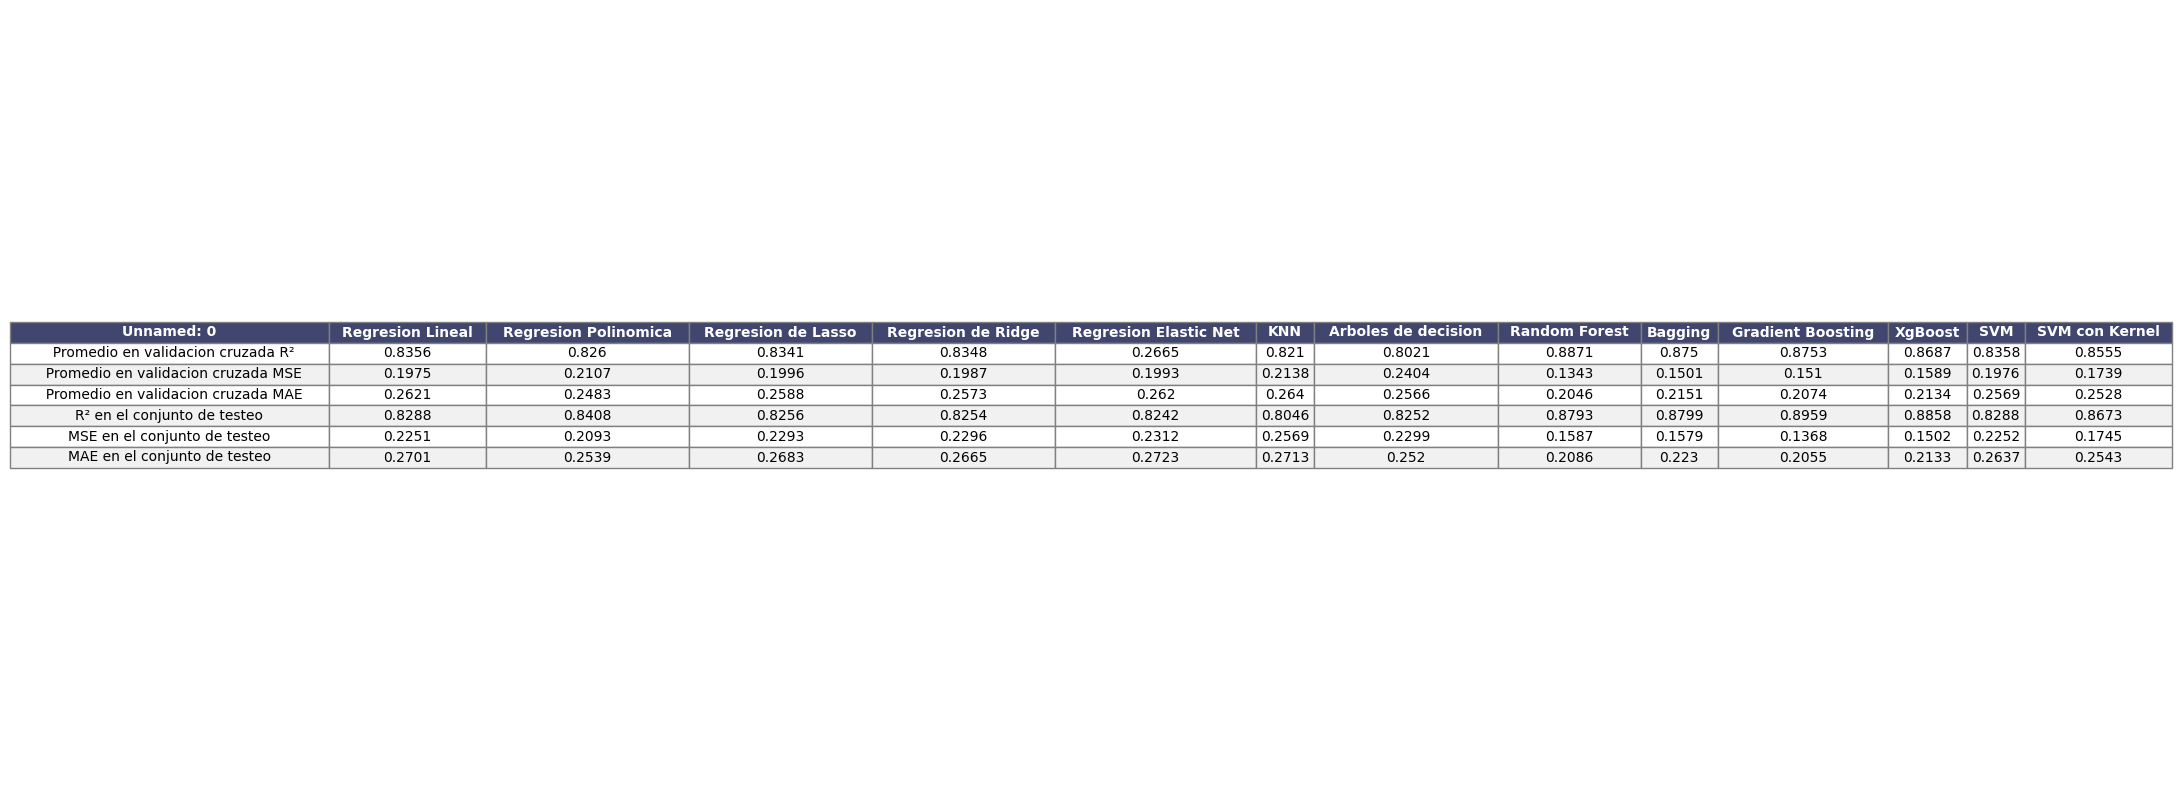

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

# Cargar los datos del archivo
file_path = 'Resultados_metricas_modelos.xlsx'
data = pd.read_excel(file_path, sheet_name='Sheet2')

# Limpiar y estructurar los datos
data_cleaned = data.dropna(how='all')

# Configuración de colores
header_color = '#40466e'
row_colors = ['#f1f1f2', '#ffffff']  # Alternando colores
cell_text = data_cleaned.values
columns = data_cleaned.columns

# Crear figura y eje
fig, ax = plt.subplots(figsize=(14, 8))  # Ajustar tamaño según los datos
ax.axis('off')  # Ocultar ejes

# Crear tabla
table = ax.table(
    cellText=cell_text,
    colLabels=columns,
    cellLoc='center',
    loc='center'
)

# Estilizar encabezados
for (i, j), cell in table.get_celld().items():
    if i == 0:
        cell.set_facecolor(header_color)
        cell.set_text_props(weight='bold', color='white')
    else:
        cell.set_facecolor(row_colors[i % len(row_colors)])
    # Agregar bordes
    cell.set_edgecolor('gray')

# Ajustar tamaño de la fuente
table.auto_set_font_size(False)
table.set_fontsize(10)

# Ajustar ancho de columnas
for i, column in enumerate(columns):
    table.auto_set_column_width(i)

plt.tight_layout()
plt.show()


El modelo de Gradient Boosting fue seleccionado debido a su destacada capacidad predictiva y precisión, como se refleja en las métricas clave:

1. R² promedio en validación cruzada (0.8753): 
   Esta métrica representa el porcentaje de la variabilidad de los datos que el modelo es capaz de explicar. Un valor cercano a 1 indica un excelente ajuste del modelo. En este caso, un R² de 0.8753 significa que el modelo puede explicar aproximadamente el 87.53% de la variabilidad de los datos en validación cruzada, lo cual es un indicador sólido de su capacidad predictiva. Este alto valor muestra que el modelo capta bien las relaciones subyacentes en los datos.

2. MSE promedio en validación cruzada (0.151):  
   El Error Cuadrático Medio (MSE) mide el promedio de los errores al cuadrado entre los valores predichos y los valores reales. Un valor más bajo indica que los errores son pequeños y consistentes. En este caso, un MSE de 0.151 refleja que el modelo comete errores pequeños en promedio durante la validación cruzada. Al ser el más bajo (junto con XGBoost), asegura una mayor precisión en las predicciones.

3. MAE promedio en validación cruzada (0.2074): 
   El Error Absoluto Medio (MAE) calcula el promedio de los errores absolutos entre las predicciones y los valores reales. A diferencia del MSE, no penaliza tanto los errores grandes, por lo que es más robusto frente a valores atípicos. En este caso, un MAE de 0.2074 implica que, en promedio, las predicciones del modelo están desviadas en 0.2074 unidades del valor real, lo cual demuestra una buena precisión.

4. R² en el conjunto de testeo (0.8959): 
   En el conjunto de prueba, este R² más alto (89.59%) refuerza la capacidad del modelo para generalizar y capturar la mayoría de la variabilidad de los datos en un conjunto no utilizado durante el entrenamiento. Este valor asegura que el modelo funciona de manera robusta incluso con datos nuevos.

5. MSE en el conjunto de testeo (0.1368):  
   En el conjunto de testeo, este bajo MSE indica que los errores promedio al cuadrado en las predicciones son mínimos, lo que respalda que el modelo tiene una alta precisión y es capaz de realizar predicciones consistentes.

6. MAE en el conjunto de testeo (0.2055):
   Finalmente, el MAE de 0.2055 en el conjunto de prueba reafirma que, en promedio, las predicciones se desvían solo 0.2055 unidades del valor real. Este valor es coherente con el bajo MSE, lo que significa que los errores son pequeños y estables.

La combinación de un R² alto (que refleja una alta capacidad explicativa) con valores bajos de MSE y MAE (indicativos de errores mínimos y consistentes) confirma que Gradient Boosting es el modelo más adecuado para este problema. No solo captura la relación entre las variables de manera efectiva, sino que también generaliza bien a datos nuevos, lo que lo convierte en una elección confiable y robusta. Además, el costo computacional (tiempo de espera) del modelo Gradient Boosting no es tan alto como otros modelos.

En el documento de Interpretaciones, abordaremos mas detalladamente el modelo a profundidad.

# Autor: Juan Esteban Londoño Guatibonza, Universidad Externado de Colombia

# Dirigido por: Daniel Godoy